<a href="https://colab.research.google.com/github/pierredantas/Decoding_Transformers_Spectra/blob/main/Decoding_Transformers_Spectra_full_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Decoding Transformers Spectra: A Random Matrix Theory Framework Beyond the Marchenko-Pastur Law

# Load BERT and extract original matrices

In [1]:
# extract_bert_matrices.py
from pathlib import Path
import json
import numpy as np
import torch
from transformers import BertModel

def extract_matrices(
    model_name: str = "bert-base-uncased",
    out_dir: str = "bert_weights",
    include_bias: bool = False,
    only_linear_like: bool = True,      # skip LayerNorm/embeddings unless they are 2-D
    dtype: str = "float32",             # "float32" | "float64"
    save_format: str = "npy",           # "npy" | "npz" (np.savez_compressed)
):
    """
    Extracts all weight matrices from a HuggingFace BERT and saves them with a manifest.
    """
    assert save_format in {"npy", "npz"}
    np_dtype = np.float32 if dtype == "float32" else np.float64

    # 1) Load model on CPU, no grad
    torch.set_grad_enabled(False)
    model = BertModel.from_pretrained(model_name)
    model.eval()
    model.to("cpu")

    out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    # 2) Iterate state_dict for robustness (covers all submodules)
    sd = model.state_dict()
    manifest = {
        "model_name": model_name,
        "dtype": dtype,
        "include_bias": include_bias,
        "only_linear_like": only_linear_like,
        "files": []
    }

    # Helper to filter which tensors to keep
    def keep_param(key: str, tensor: torch.Tensor) -> bool:
        # Want weights (2-D) from linear/attention/FFN; optionally biases (1-D)
        if tensor.ndim == 2:
            # Typically Linear weights, embedding matrices (2-D), etc.
            if only_linear_like:
                # Heuristics: keep common linear/attention/FFN matrices
                names_we_like = (
                    "encoder.layer", "attention", "intermediate", "output.dense",
                    "self.query", "self.key", "self.value", "dense", "pooler.dense"
                )
                return any(n in key for n in names_we_like)
            return True

        if include_bias and tensor.ndim == 1:
            # keep biases if requested
            names_we_like = ("bias",)
            return any(n in key for n in names_we_like)

        return False

    # 3) Save tensors and record metadata
    for key in sorted(sd.keys()):
        t = sd[key]
        if not keep_param(key, t):
            continue

        arr = t.detach().cpu().to(dtype=torch.float32 if dtype == "float32" else torch.float64).numpy()

        # Build a safe, hierarchical path
        # Example key: "encoder.layer.0.attention.self.query.weight"
        # -> encoder/layer_0/attention/self/query/weight.npy
        parts = key.split(".")
        # normalize "layer.N" to "layer_N"
        norm_parts = []
        for p in parts:
            if p == "layer":
                continue
            if p.isdigit():  # the index that follows "layer"
                norm_parts.append(f"layer_{p}")
            else:
                norm_parts.append(p)

        # Put under base directory
        save_dir = out.joinpath(*norm_parts[:-1])  # all but the last (usually "weight" or "bias")
        save_dir.mkdir(parents=True, exist_ok=True)

        stem = norm_parts[-1]  # "weight" or "bias"
        ext = ".npy" if save_format == "npy" else ".npz"
        path = save_dir / f"{stem}{ext}"

        if save_format == "npy":
            np.save(path, arr)
        else:
            np.savez_compressed(path, data=arr)

        manifest["files"].append({
            "name": key,
            "path": str(path.relative_to(out)),
            "shape": list(arr.shape),
            "ndim": arr.ndim,
            "dtype": str(arr.dtype)
        })

    # 4) Also save a flat copy for embeddings if you want them explicitly grouped
    # (Optional—comment out if you don't need a separate embeddings folder)
    emb_dir = out / "embeddings"
    emb_dir.mkdir(exist_ok=True)
    for subkey, param in model.embeddings.state_dict().items():
        if param.ndim == 2 or (include_bias and param.ndim == 1):
            arr = param.detach().cpu().to(dtype=torch.float32 if dtype == "float32" else torch.float64).numpy()
            fname = (subkey.replace(".", "_") + ("_bias" if subkey.endswith("bias") else "") +
                     (".npy" if save_format == "npy" else ".npz"))
            path = emb_dir / fname
            if save_format == "npy":
                np.save(path, arr)
            else:
                np.savez_compressed(path, data=arr)

            manifest["files"].append({
                "name": f"embeddings.{subkey}",
                "path": str(path.relative_to(out)),
                "shape": list(arr.shape),
                "ndim": arr.ndim,
                "dtype": str(arr.dtype)
            })

    # 5) Write manifest
    with open(out / "manifest.json", "w") as f:
        json.dump(manifest, f, indent=2)

    print(f"Saved to: {out.resolve()}")
    print(f"Total tensors saved: {len(manifest['files'])}")

if __name__ == "__main__":
    extract_matrices(
        model_name="bert-base-uncased",
        out_dir="bert_weights",
        include_bias=False,
        only_linear_like=True,
        dtype="float32",
        save_format="npy",
    )

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Saved to: /content/bert_weights
Total tensors saved: 76


# Build Wn and save stats

In [2]:
# =========================
# Build WMP and save stats for inversion
# =========================
# Inputs:
#   - bert_weights/ (from extract_bert_matrices.py)
# Outputs:
#   - step1_column_stats.json   (human-readable, key map)
#   - step1_column_stats.npz    (exact np arrays of means/stds)
#   - bert_weights_WMP/          (normalized matrices) + manifest.json

import json
import re
from datetime import datetime, UTC
from pathlib import Path
import numpy as np

WEIGHTS_DIR = "bert_weights"
STATS_JSON  = "step1_column_stats.json"
STATS_NPZ   = "step1_column_stats.npz"
WMP_DIR      = "bert_weights_WMP"

def _safe_key(idx: int, kind: str, name: str) -> str:
    """Create stable NPZ keys like '0003__mean__encoder_layer_0_attention_self_query_weight'."""
    base = f"{idx:04d}__{kind}__" + re.sub(r"[^0-9a-zA-Z_]+", "_", name)
    base = re.sub(r"__+", "__", base).strip("_")
    return base[:200]

def _load_matrix(path: Path) -> np.ndarray:
    if path.suffix == ".npy":
        return np.load(path)
    if path.suffix == ".npz":
        return np.load(path)["data"]
    raise ValueError(f"Unsupported file type: {path.suffix}")

def _save_npy(path: Path, arr: np.ndarray) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    np.save(path, arr)

# ------------- Step 1: compute and save column-wise stats -------------
weights_dir = Path(WEIGHTS_DIR)
manifest_path = weights_dir / "manifest.json"
assert manifest_path.exists(), f"Manifest not found at {manifest_path}"

with open(manifest_path, "r") as f:
    manifest = json.load(f)

npz_store = {}
stats_json = {
    "model_name": manifest.get("model_name", ""),
    "created_at": datetime.now(UTC).isoformat(),
    "weights_dir": str(weights_dir),
    "count_files": 0,
    "files": []
}

files = manifest.get("files", [])
processed = 0
for idx, entry in enumerate(files):
    relpath = entry.get("path")
    name    = entry.get("name", relpath)
    shape   = entry.get("shape")

    fpath = weights_dir / relpath
    if not fpath.exists():
        print(f"[MISS] {relpath}")
        continue

    try:
        W = _load_matrix(fpath)
    except Exception as e:
        print(f"[LOAD-ERR] {relpath}: {e}")
        continue

    if W.ndim != 2:
        continue  # only 2-D matrices

    # Column-wise stats (axis=0); compute in float64 for stability
    W = W.astype(np.float64, copy=False)
    mu = W.mean(axis=0)          # shape (n,)
    sd = W.std(axis=0)           # shape (n,)

    mean_key = _safe_key(idx, "mean", name)
    std_key  = _safe_key(idx, "std",  name)
    npz_store[mean_key] = mu
    npz_store[std_key]  = sd

    stats_json["files"].append({
        "index": idx,
        "name": name,
        "path": relpath,
        "shape": shape,
        "npz_keys": {"mean": mean_key, "std": std_key},
        "summary": {
            "mean_of_means": float(mu.mean()),
            "mean_of_stds": float(sd.mean()),
            "max_std": float(sd.max()),
            "min_std": float(sd.min())
        }
    })
    processed += 1
    if processed % 25 == 0:
        print(f"[STATS] Processed {processed} matrices...")

stats_json["count_files"] = processed

with open(STATS_JSON, "w") as jf:
    json.dump(stats_json, jf, indent=2)
np.savez_compressed(STATS_NPZ, **npz_store)

print(f"[STATS] Done. Matrices processed: {processed}")
print(f"[STATS] JSON: {STATS_JSON}")
print(f"[STATS] NPZ : {STATS_NPZ}")

# ------------- Step 2: build WMP=(W - 1*mu)/sd and save with manifest -------------
out_root = Path(WMP_DIR)
out_root.mkdir(parents=True, exist_ok=True)

# prepare WMP manifest (clone key fields)
wmp_manifest = {
    "model_name": manifest.get("model_name", "") + " (column-standardized)",
    "dtype": "float64",
    "include_bias": manifest.get("include_bias", False),
    "only_linear_like": manifest.get("only_linear_like", True),
    "files": []
}

stats_npz = np.load(STATS_NPZ)

saved = 0
skipped = 0
for entry in stats_json["files"]:
    relpath = entry["path"]
    name    = entry["name"]
    mu      = stats_npz[entry["npz_keys"]["mean"]]  # (n,)
    sd      = stats_npz[entry["npz_keys"]["std"]]   # (n,)

    src_path = weights_dir / relpath
    if not src_path.exists():
        print(f"[MISS-WMP] {relpath}")
        continue

    W = _load_matrix(src_path)
    if W.ndim != 2:
        skipped += 1
        continue

    W = W.astype(np.float64, copy=False)

    # Guard zero-variance columns; they remain constant after normalization
    safe_sd = np.where(sd == 0, 1.0, sd)

    # WMP = (W - 1*mu)/sd  -> broadcast along rows (axis=0)
    WMP = (W - mu.reshape(1, -1)) / safe_sd.reshape(1, -1)

    dst_path = out_root / relpath
    _save_npy(dst_path, WMP)

    wmp_manifest["files"].append({
        "name": name.replace(".weight", ".weight_WMP"),
        "path": str(dst_path.relative_to(out_root)),
        "shape": list(WMP.shape),
        "ndim": 2,
        "dtype": str(WMP.dtype)
    })
    saved += 1
    if saved % 25 == 0:
        print(f"[WMP] Saved {saved} matrices...")

with open(out_root / "manifest.json", "w") as f:
    json.dump(wmp_manifest, f, indent=2)

# ------------- Quick verification on a few matrices -------------
from itertools import islice

def _check_one(relpath: str, mu: np.ndarray, sd: np.ndarray) -> float:
    W  = _load_matrix(weights_dir / relpath).astype(np.float64)
    WMP = _load_matrix(out_root / relpath).astype(np.float64)
    safe_sd = np.where(sd == 0, 1.0, sd)
    W_rec = WMP * safe_sd.reshape(1, -1) + mu.reshape(1, -1)
    return float(np.max(np.abs(W - W_rec)))

print("====================================================")
print(f"✅ WMP saved: {saved} | Skipped (non-2D): {skipped}")
print(f"Manifest written: {out_root / 'manifest.json'}")

# Pick up to 3 entries and verify round-trip reconstruction
errs = []
for e in islice(stats_json["files"], 3):
    rel = e["path"]
    mu  = stats_npz[e["npz_keys"]["mean"]]
    sd  = stats_npz[e["npz_keys"]["std"]]
    errs.append((rel, _check_one(rel, mu, sd)))
for rel, err in errs:
    print(f"[CHECK] {rel}: max |W - (WMP*sd+mu)| = {err:.3e}")
print("====================================================")


[STATS] Processed 25 matrices...
[STATS] Processed 50 matrices...
[STATS] Processed 75 matrices...
[STATS] Done. Matrices processed: 76
[STATS] JSON: step1_column_stats.json
[STATS] NPZ : step1_column_stats.npz
[WMP] Saved 25 matrices...
[WMP] Saved 50 matrices...
[WMP] Saved 75 matrices...
✅ WMP saved: 76 | Skipped (non-2D): 0
Manifest written: bert_weights_WMP/manifest.json
[CHECK] encoder/layer_0/attention/output/dense/weight.npy: max |W - (WMP*sd+mu)| = 2.776e-17
[CHECK] encoder/layer_0/attention/self/key/weight.npy: max |W - (WMP*sd+mu)| = 1.110e-16
[CHECK] encoder/layer_0/attention/self/query/weight.npy: max |W - (WMP*sd+mu)| = 5.551e-17


# Graph 1 - Empirical PDF (ePDF) vs. conditional MPd PDF under different trimming conditions.

▶ PARAMETERS USED FOR MOSAIC (line=row, column=col)
[row 1, col 1] Set 1 — baseline
- Matrix name   : encoder.layer.0.intermediate.dense.weight_WMP
- Shape (m,n)   : (3072, 768)
- Aspect ratio β: 0.250000
- λ- , λ+       : [0.250000, 2.250000]
- Trimming rule : tw_or_fraction (c_TW=2.0, EDGE_FRAC_SQ=0.05, EDGE_FRAC_RECT=0.05)
- Trim interval : [L,U] = [0.350000, 2.150000]
- Eigenvalues   : kept 595/3072 after trimming
- Histogram bins: 150
----------------------------------------
[row 1, col 2] Set 2 — tight TW
- Matrix name   : encoder.layer.0.intermediate.dense.weight_WMP
- Shape (m,n)   : (3072, 768)
- Aspect ratio β: 0.250000
- λ- , λ+       : [0.250000, 2.250000]
- Trimming rule : tw_or_fraction (c_TW=1.0, EDGE_FRAC_SQ=0.05, EDGE_FRAC_RECT=0.05)
- Trim interval : [L,U] = [0.350000, 2.150000]
- Eigenvalues   : kept 595/3072 after trimming
- Histogram bins: 150
----------------------------------------
[row 1, col 3] Set 3 — loose trim
- Matrix name   : encoder.layer.0.intermediate.d

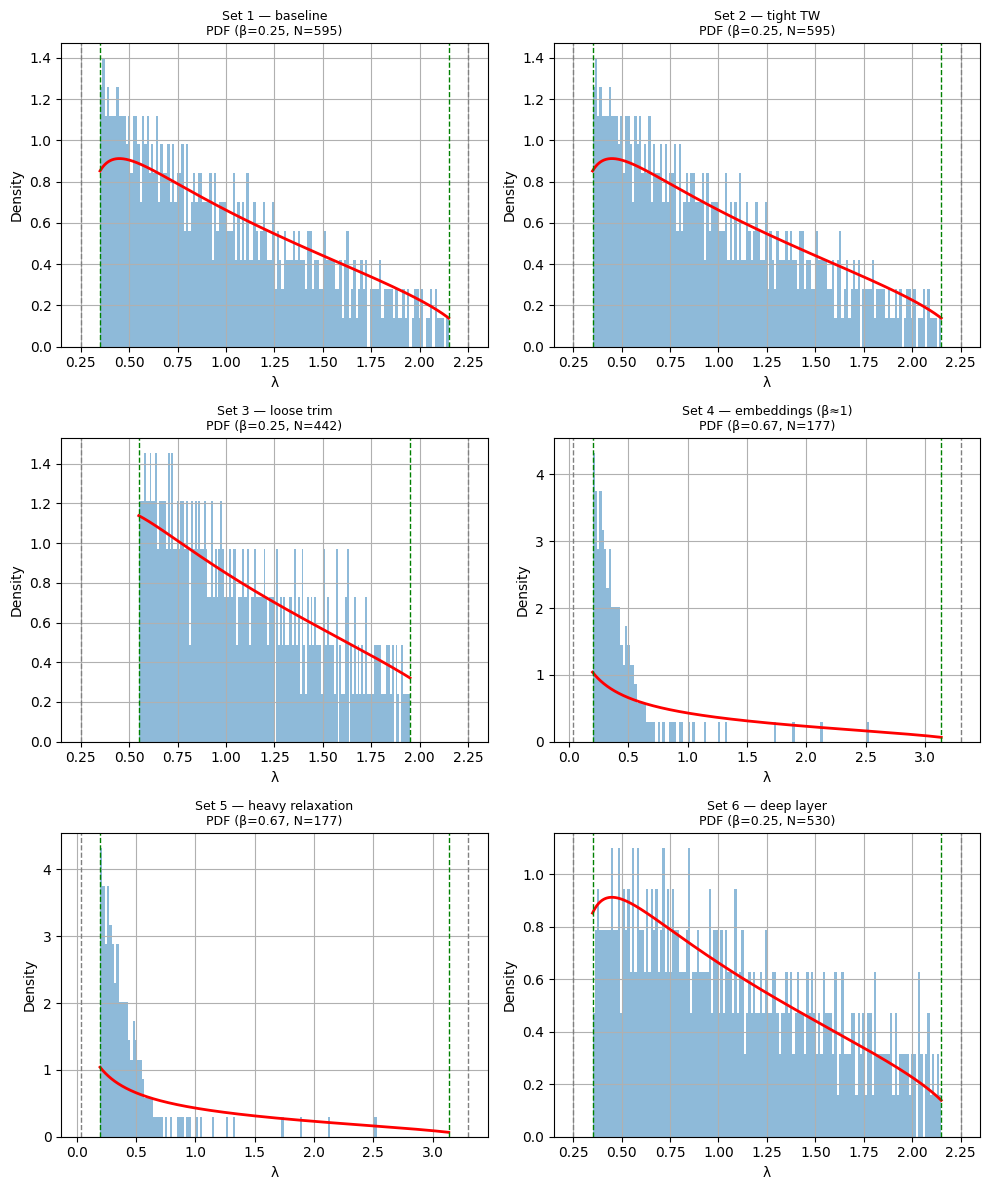

In [3]:
# --- Mosaic plots for six parameter sets (PDFs) ---
# Purpose: Generate mosaic plots comparing empirical and theoretical
#          eigenvalue distributions for various matrix settings.
# Prereq: "bert_weights_WMP/manifest.json" exists and contains standardized matrices.

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Helpers
# =========================
def _load_matrix(p: Path):
    """Loads a NumPy matrix from a .npy or .npz file."""
    if p.suffix == ".npy":  return np.load(p)
    if p.suffix == ".npz":  return np.load(p)["data"]
    raise ValueError(f"Unsupported file type: {p.suffix}")

def _mp_support(beta: float):
    """Calculates the Marchenko-Pastur support bounds."""
    r = np.sqrt(beta); return (1 - r)**2, (1 + r)**2

def _mp_pdf(x, beta, a, b):
    """Calculates the Marchenko-Pastur PDF."""
    x = np.asarray(x, dtype=np.float64)
    out = np.zeros_like(x)
    m = (x >= a) & (x <= b)
    xm = np.clip(x[m], 1e-15, None)
    out[m] = np.sqrt((b - xm) * (xm - a)) / (2 * np.pi * beta * xm)
    return out

def _cumtrapz_np(y, x):
    """Performs cumulative trapezoidal integration on NumPy arrays."""
    dx = np.diff(x); seg = 0.5 * (y[:-1] + y[1:]) * dx
    return np.concatenate([[0.0], np.cumsum(seg)])

def _mp_cdf(x, beta, grid_points=8192):
    """Calculates the Marchenko-Pastur CDF using numerical integration."""
    a, b = _mp_support(beta)
    t = np.linspace(0.0, 1.0, grid_points)
    g = a + (b - a) * t * t
    pdf = _mp_pdf(g, beta, a, b)
    cdf_vals = _cumtrapz_np(pdf, g)
    cdf_vals /= cdf_vals[-1]
    return np.interp(x, g, cdf_vals, left=0.0, right=1.0)

def _edge_margin(beta, m, n, trim_kind, c_tw, frac_sq, frac_rect):
    """Determines the trimming margin based on different rules."""
    a, b = _mp_support(beta); bandwidth = b - a
    n_eff = min(m, n); is_square = (m == n)
    tw = c_tw * (n_eff ** (-2/3)) * (1 + np.sqrt(beta))**(4/3)
    frac = (frac_sq if is_square else frac_rect) * bandwidth
    if trim_kind == "tw": return tw
    if trim_kind == "fraction": return frac
    if trim_kind == "tw_or_fraction": return max(tw, frac)
    raise ValueError("Invalid trim_kind")

def _find_manifest_entry(manifest, target):
    """Finds a matrix entry in the manifest file."""
    for e in manifest["files"]:
        if e.get("name","") == target: return e
    for e in manifest["files"]:
        if target in e.get("name","") or target in e.get("path",""): return e
    raise ValueError(f"Matrix '{target}' not found in manifest")

def compute_trimmed(W, TRIM_KIND, C_TW, EDGE_FRAC_SQUARE, EDGE_FRAC_RECT):
    """Computes trimmed eigenvalues and conditional MP distributions."""
    m,n = W.shape; beta = min(m,n)/max(m,n)
    s = np.linalg.svd(W, full_matrices=False, compute_uv=False)
    lambdas = (s**2)/max(m,n); lambdas.sort()
    a,b = _mp_support(beta)
    delta = _edge_margin(beta,m,n,TRIM_KIND,C_TW,EDGE_FRAC_SQUARE,EDGE_FRAC_RECT)
    L,U = a+delta, b-delta
    if L>=U: L,U=a,b
    mask = (lambdas>=L)&(lambdas<=U)
    lam_trim = lambdas[mask]; N_trim = lam_trim.size
    FL,FU = _mp_cdf([L,U], beta); den = max(FU-FL,1e-12)
    mp_pdf_cond = lambda x: _mp_pdf(x,beta,a,b)/den
    mp_cdf_cond = lambda x: np.clip((_mp_cdf(x,beta)-FL)/den,0,1)
    return lam_trim, (a,b,L,U,beta), mp_pdf_cond, mp_cdf_cond, N_trim

# =========================
# Config
# =========================
WMP_DIR = "bert_weights_WMP"
GRID_POINTS = 8192
COND_GRID = 2000
HIST_BINS = 150

# Define parameter sets exactly as specified
SETTINGS = [
    dict(name="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=2.0, frac_sq=0.05, frac_rect=0.05, label="Set 1 — baseline"),
    dict(name="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=1.0, frac_sq=0.05, frac_rect=0.05, label="Set 2 — tight TW"),
    dict(name="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="fraction", c_tw=1.0, frac_sq=0.05, frac_rect=0.15, label="Set 3 — loose trim"),
    dict(name="embeddings.position_embeddings.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=2.0, frac_sq=0.05, frac_rect=0.05, label="Set 4 — embeddings (β≈1)"),
    dict(name="embeddings.position_embeddings.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=3.0, frac_sq=0.05, frac_rect=0.05, label="Set 5 — heavy relaxation"),
    dict(name="encoder.layer.11.output.dense.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=2.0, frac_sq=0.05, frac_rect=0.05, label="Set 6 — deep layer"),
]

# Load manifest once
man_path = Path(WMP_DIR) / "manifest.json"
manifest = json.load(open(man_path))

# =========================
# MOSAIC: PDFs
# =========================
fig, axes = plt.subplots(3, 2, figsize=(10,12))
axes = axes.flatten()

for ax, cfg in zip(axes, SETTINGS):
    entry = _find_manifest_entry(manifest, cfg["name"])
    W = _load_matrix(Path(WMP_DIR)/entry["path"]).astype(np.float64, copy=False)
    lam_trim,(a,b,L,U,beta),mp_pdf_cond,mp_cdf_cond,N_trim = compute_trimmed(
        W, cfg["trim_kind"], cfg["c_tw"], cfg["frac_sq"], cfg["frac_rect"]
    )
    x_grid = np.linspace(L,U,COND_GRID)
    if N_trim>0:
        ax.hist(lam_trim,bins=HIST_BINS,range=(L,U),density=True,alpha=0.5)
    ax.plot(x_grid, mp_pdf_cond(x_grid),'r-',lw=2)
    for v,col in [(a,"gray"),(b,"gray"),(L,"g"),(U,"g")]:
        ax.axvline(v,color=col,linestyle="--",lw=1)
    ax.set_title(f"{cfg['label']}\nPDF (β={beta:.2f}, N={N_trim})",fontsize=9)
    ax.set_xlabel("λ"); ax.set_ylabel("Density"); ax.grid(True)

plt.tight_layout()
plt.savefig("graph_core_diag_01.pdf", format="pdf")

# =========================
# Print PARAMETERS summary for each subplot
# =========================
print("="*60)
print("▶ PARAMETERS USED FOR MOSAIC (line=row, column=col)")
for i, cfg in enumerate(SETTINGS):
    row, col = divmod(i, 3)
    entry = _find_manifest_entry(manifest, cfg["name"])
    W = _load_matrix(Path(WMP_DIR)/entry["path"]).astype(np.float64, copy=False)
    lam_trim,(a,b,L,U,beta),mp_pdf_cond,mp_cdf_cond,N_trim = compute_trimmed(
        W, cfg["trim_kind"], cfg["c_tw"], cfg["frac_sq"], cfg["frac_rect"]
    )
    print(f"[row {row+1}, col {col+1}] {cfg['label']}")
    print(f"- Matrix name   : {cfg['name']}")
    print(f"- Shape (m,n)   : {W.shape}")
    print(f"- Aspect ratio β: {beta:.6f}")
    print(f"- λ- , λ+       : [{a:.6f}, {b:.6f}]")
    print(f"- Trimming rule : {cfg['trim_kind']} (c_TW={cfg['c_tw']}, "
          f"EDGE_FRAC_SQ={cfg['frac_sq']}, EDGE_FRAC_RECT={cfg['frac_rect']})")
    print(f"- Trim interval : [L,U] = [{L:.6f}, {U:.6f}]")
    print(f"- Eigenvalues   : kept {N_trim}/{len(W)} after trimming")
    print(f"- Histogram bins: {HIST_BINS}")
    print("-"*40)
print("="*60)

# Graph 2 - Empirical CDF (eCDF) vs. conditional MPd CDF under different trimming conditions.

▶ PARAMETERS USED FOR MOSAIC (line=row, column=col)
[row 1, col 1] Set 1 — baseline
- Matrix name   : encoder.layer.0.intermediate.dense.weight_WMP
- Shape (m,n)   : (3072, 768)
- Aspect ratio β: 0.250000
- λ- , λ+       : [0.250000, 2.250000]
- Trimming rule : tw_or_fraction (c_TW=2.0, EDGE_FRAC_SQ=0.05, EDGE_FRAC_RECT=0.05)
- Trim interval : [L,U] = [0.350000, 2.150000]
- Eigenvalues   : kept 595/3072 after trimming
- Histogram bins: 150
----------------------------------------
[row 1, col 2] Set 2 — tight TW
- Matrix name   : encoder.layer.0.intermediate.dense.weight_WMP
- Shape (m,n)   : (3072, 768)
- Aspect ratio β: 0.250000
- λ- , λ+       : [0.250000, 2.250000]
- Trimming rule : tw_or_fraction (c_TW=1.0, EDGE_FRAC_SQ=0.05, EDGE_FRAC_RECT=0.05)
- Trim interval : [L,U] = [0.350000, 2.150000]
- Eigenvalues   : kept 595/3072 after trimming
- Histogram bins: 150
----------------------------------------
[row 1, col 3] Set 3 — loose trim
- Matrix name   : encoder.layer.0.intermediate.d

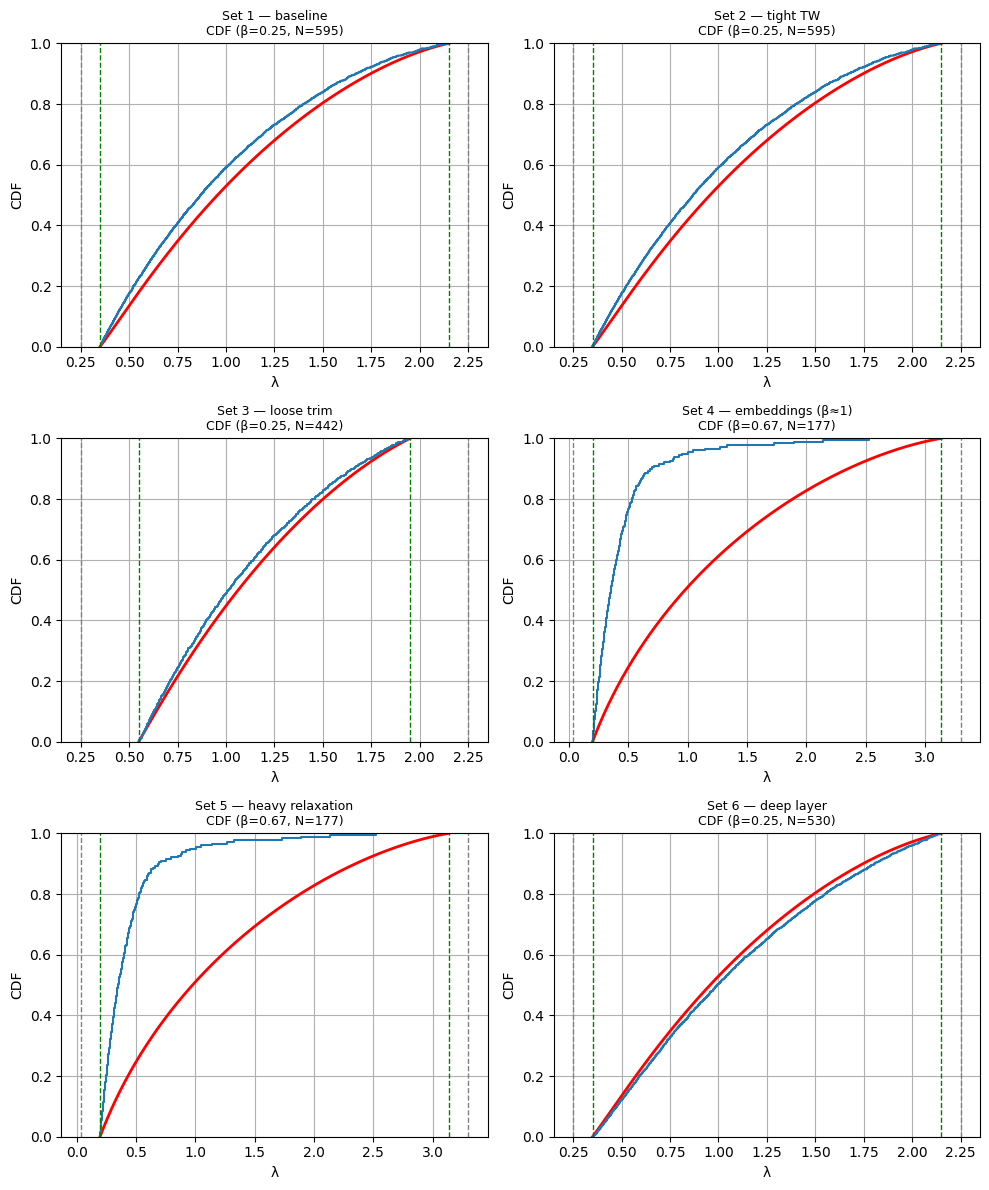

In [4]:
# --- Mosaic plots for six parameter sets (CDFs) ---
# Purpose: Generate mosaic plots comparing empirical and theoretical
#          eigenvalue distributions for various matrix settings.
# Prereq: "bert_weights_WMP/manifest.json" exists and contains standardized matrices.

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Helpers
# =========================
def _load_matrix(p: Path):
    """Loads a NumPy matrix from a .npy or .npz file."""
    if p.suffix == ".npy":  return np.load(p)
    if p.suffix == ".npz":  return np.load(p)["data"]
    raise ValueError(f"Unsupported file type: {p.suffix}")

def _mp_support(beta: float):
    """Calculates the Marchenko-Pastur support bounds."""
    r = np.sqrt(beta); return (1 - r)**2, (1 + r)**2

def _mp_pdf(x, beta, a, b):
    """Calculates the Marchenko-Pastur PDF."""
    x = np.asarray(x, dtype=np.float64)
    out = np.zeros_like(x)
    m = (x >= a) & (x <= b)
    xm = np.clip(x[m], 1e-15, None)
    out[m] = np.sqrt((b - xm) * (xm - a)) / (2 * np.pi * beta * xm)
    return out

def _cumtrapz_np(y, x):
    """Performs cumulative trapezoidal integration on NumPy arrays."""
    dx = np.diff(x); seg = 0.5 * (y[:-1] + y[1:]) * dx
    return np.concatenate([[0.0], np.cumsum(seg)])

def _mp_cdf(x, beta, grid_points=8192):
    """Calculates the Marchenko-Pastur CDF using numerical integration."""
    a, b = _mp_support(beta)
    t = np.linspace(0.0, 1.0, grid_points)
    g = a + (b - a) * t * t
    pdf = _mp_pdf(g, beta, a, b)
    cdf_vals = _cumtrapz_np(pdf, g)
    cdf_vals /= cdf_vals[-1]
    return np.interp(x, g, cdf_vals, left=0.0, right=1.0)

def _edge_margin(beta, m, n, trim_kind, c_tw, frac_sq, frac_rect):
    """Determines the trimming margin based on different rules."""
    a, b = _mp_support(beta); bandwidth = b - a
    n_eff = min(m, n); is_square = (m == n)
    tw = c_tw * (n_eff ** (-2/3)) * (1 + np.sqrt(beta))**(4/3)
    frac = (frac_sq if is_square else frac_rect) * bandwidth
    if trim_kind == "tw": return tw
    if trim_kind == "fraction": return frac
    if trim_kind == "tw_or_fraction": return max(tw, frac)
    raise ValueError("Invalid trim_kind")

def _find_manifest_entry(manifest, target):
    """Finds a matrix entry in the manifest file."""
    for e in manifest["files"]:
        if e.get("name","") == target: return e
    for e in manifest["files"]:
        if target in e.get("name","") or target in e.get("path",""): return e
    raise ValueError(f"Matrix '{target}' not found in manifest")

def compute_trimmed(W, TRIM_KIND, C_TW, EDGE_FRAC_SQUARE, EDGE_FRAC_RECT):
    """Computes trimmed eigenvalues and conditional MP distributions."""
    m,n = W.shape; beta = min(m,n)/max(m,n)
    s = np.linalg.svd(W, full_matrices=False, compute_uv=False)
    lambdas = (s**2)/max(m,n); lambdas.sort()
    a,b = _mp_support(beta)
    delta = _edge_margin(beta,m,n,TRIM_KIND,C_TW,EDGE_FRAC_SQUARE,EDGE_FRAC_RECT)
    L,U = a+delta, b-delta
    if L>=U: L,U=a,b
    mask = (lambdas>=L)&(lambdas<=U)
    lam_trim = lambdas[mask]; N_trim = lam_trim.size
    FL,FU = _mp_cdf([L,U], beta); den = max(FU-FL,1e-12)
    mp_pdf_cond = lambda x: _mp_pdf(x,beta,a,b)/den
    mp_cdf_cond = lambda x: np.clip((_mp_cdf(x,beta)-FL)/den,0,1)
    return lam_trim, (a,b,L,U,beta), mp_pdf_cond, mp_cdf_cond, N_trim

# =========================
# Config
# =========================
WMP_DIR = "bert_weights_WMP"
GRID_POINTS = 8192
COND_GRID = 2000
HIST_BINS = 150

# Define parameter sets exactly as specified
SETTINGS = [
    dict(name="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=2.0, frac_sq=0.05, frac_rect=0.05, label="Set 1 — baseline"),
    dict(name="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=1.0, frac_sq=0.05, frac_rect=0.05, label="Set 2 — tight TW"),
    dict(name="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="fraction", c_tw=1.0, frac_sq=0.05, frac_rect=0.15, label="Set 3 — loose trim"),
    dict(name="embeddings.position_embeddings.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=2.0, frac_sq=0.05, frac_rect=0.05, label="Set 4 — embeddings (β≈1)"),
    dict(name="embeddings.position_embeddings.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=3.0, frac_sq=0.05, frac_rect=0.05, label="Set 5 — heavy relaxation"),
    dict(name="encoder.layer.11.output.dense.weight_WMP",
         trim_kind="tw_or_fraction", c_tw=2.0, frac_sq=0.05, frac_rect=0.05, label="Set 6 — deep layer"),
]

# Load manifest once
man_path = Path(WMP_DIR) / "manifest.json"
manifest = json.load(open(man_path))

# =========================
# MOSAIC: CDFs
# =========================
fig, axes = plt.subplots(3, 2, figsize=(10,12))
axes = axes.flatten()

for ax, cfg in zip(axes, SETTINGS):
    entry = _find_manifest_entry(manifest, cfg["name"])
    W = _load_matrix(Path(WMP_DIR)/entry["path"]).astype(np.float64, copy=False)
    lam_trim,(a,b,L,U,beta),mp_pdf_cond,mp_cdf_cond,N_trim = compute_trimmed(
        W, cfg["trim_kind"], cfg["c_tw"], cfg["frac_sq"], cfg["frac_rect"]
    )
    x_grid = np.linspace(L,U,COND_GRID)
    ax.plot(x_grid, mp_cdf_cond(x_grid),'r-',lw=2,label="MP CDF")
    if N_trim>0:
        y_ecdf = np.arange(1,N_trim+1)/N_trim
        ax.step(lam_trim,y_ecdf,where="post",label="Empirical CDF")
    for v,col in [(a,"gray"),(b,"gray"),(L,"g"),(U,"g")]:
        ax.axvline(v,color=col,linestyle="--",lw=1)
    ax.set_title(f"{cfg['label']}\nCDF (β={beta:.2f}, N={N_trim})",fontsize=9)
    ax.set_xlabel("λ"); ax.set_ylabel("CDF"); ax.set_ylim(0,1); ax.grid(True)

plt.tight_layout()
plt.savefig("graph_core_diag_02.pdf", format="pdf")

# =========================
# Print PARAMETERS summary for each subplot
# =========================
print("="*60)
print("▶ PARAMETERS USED FOR MOSAIC (line=row, column=col)")
for i, cfg in enumerate(SETTINGS):
    row, col = divmod(i, 3)
    entry = _find_manifest_entry(manifest, cfg["name"])
    W = _load_matrix(Path(WMP_DIR)/entry["path"]).astype(np.float64, copy=False)
    lam_trim,(a,b,L,U,beta),mp_pdf_cond,mp_cdf_cond,N_trim = compute_trimmed(
        W, cfg["trim_kind"], cfg["c_tw"], cfg["frac_sq"], cfg["frac_rect"]
    )
    print(f"[row {row+1}, col {col+1}] {cfg['label']}")
    print(f"- Matrix name   : {cfg['name']}")
    print(f"- Shape (m,n)   : {W.shape}")
    print(f"- Aspect ratio β: {beta:.6f}")
    print(f"- λ- , λ+       : [{a:.6f}, {b:.6f}]")
    print(f"- Trimming rule : {cfg['trim_kind']} (c_TW={cfg['c_tw']}, "
          f"EDGE_FRAC_SQ={cfg['frac_sq']}, EDGE_FRAC_RECT={cfg['frac_rect']})")
    print(f"- Trim interval : [L,U] = [{L:.6f}, {U:.6f}]")
    print(f"- Eigenvalues   : kept {N_trim}/{len(W)} after trimming")
    print(f"- Histogram bins: {HIST_BINS}")
    print("-"*40)
print("="*60)

# Graph 3 - Empirical PDF (ePDF) vs. conditional MPd PDF across selected layers and matrix types.



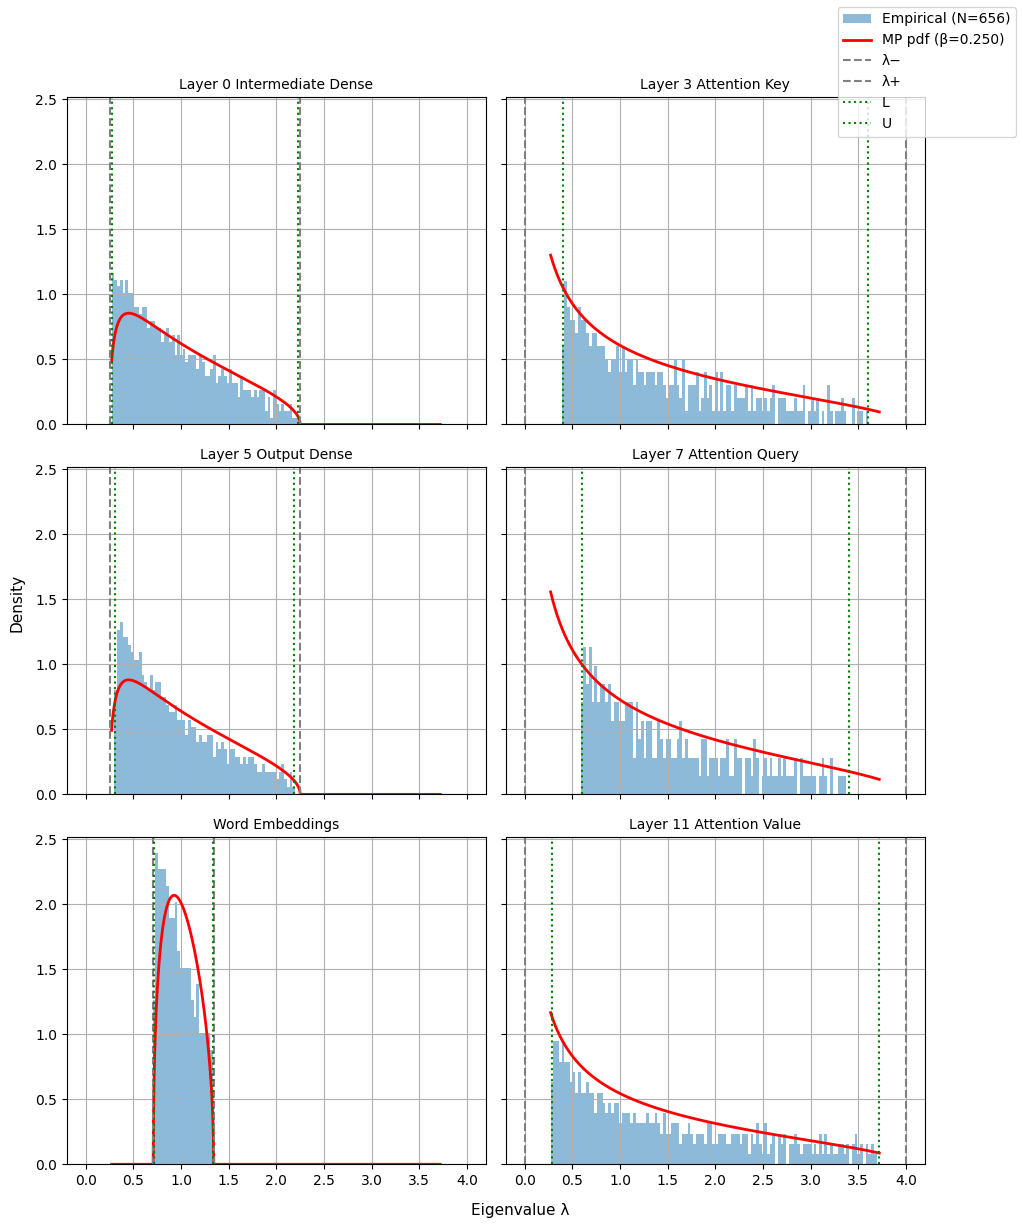

In [5]:
# --- Graph #2: Empirical density vs MP pdf (trimmed interior) ---
# 2x3 subplot mosaic with same axis scale across all graphs.

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
WMP_DIR = "bert_weights_WMP"

param_sets = [
    # (target, TRIM_KIND, C_TW, EDGE_FRAC_SQUARE, EDGE_FRAC_RECT, title)
    ("encoder.layer.0.intermediate.dense.weight_WMP", "tw",            1.0, 0.05, 0.05, "Layer 0 Intermediate Dense"),
    ("encoder.layer.3.attention.self.key.weight_WMP", "fraction",      None, 0.10, 0.08, "Layer 3 Attention Key"),
    ("encoder.layer.5.output.dense.weight_WMP",       "tw_or_fraction",3.0, 0.05, 0.03, "Layer 5 Output Dense"),
    ("encoder.layer.7.attention.self.query.weight_WMP","fraction",     None, 0.15, 0.10, "Layer 7 Attention Query"),
    ("embeddings.word_embeddings.weight_WMP",         "tw",            0.5, 0.07, 0.07, "Word Embeddings"),
    ("encoder.layer.11.attention.self.value.weight_WMP","tw_or_fraction",2.5,0.07,0.05, "Layer 11 Attention Value"),
]

GRID_POINTS = 8192
COND_GRID   = 2000
HIST_BINS   = 120

# =========================
# Helpers (from baseline)
# =========================
def _load_matrix(p: Path):
    if p.suffix == ".npy":  return np.load(p)
    if p.suffix == ".npz":  return np.load(p)["data"]
    raise ValueError(f"Unsupported file type: {p.suffix}")

def _mp_support(beta: float):
    r = np.sqrt(beta); return (1 - r)**2, (1 + r)**2

def _mp_pdf(x, beta, a, b):
    x = np.asarray(x, dtype=np.float64)
    out = np.zeros_like(x)
    m = (x >= a) & (x <= b)
    xm = np.clip(x[m], 1e-15, None)
    out[m] = np.sqrt((b - xm) * (xm - a)) / (2 * np.pi * beta * xm)
    return out

def _cumtrapz_np(y, x):
    dx = np.diff(x); seg = 0.5 * (y[:-1] + y[1:]) * dx
    return np.concatenate([[0.0], np.cumsum(seg)])

def _mp_cdf(x, beta, grid_points=GRID_POINTS):
    a, b = _mp_support(beta)
    t = np.linspace(0.0, 1.0, grid_points)
    g = a + (b - a) * t * t
    pdf = _mp_pdf(g, beta, a, b)
    cdf_vals = _cumtrapz_np(pdf, g)
    cdf_vals /= cdf_vals[-1]
    return np.interp(x, g, cdf_vals, left=0.0, right=1.0)

def _edge_margin(beta, m, n, trim_kind, c_tw, frac_sq, frac_rect):
    a, b = _mp_support(beta); bandwidth = b - a
    n_eff = min(m, n); is_square = (m == n)
    tw = 0.0 if c_tw is None else c_tw * (n_eff ** (-2/3)) * (1 + np.sqrt(beta))**(4/3)
    frac = (frac_sq if is_square else frac_rect) * bandwidth
    if trim_kind == "tw": return tw
    if trim_kind == "fraction": return frac
    if trim_kind == "tw_or_fraction": return max(tw, frac)
    raise ValueError("Invalid trim_kind")

def _find_manifest_entry(manifest, target):
    for e in manifest["files"]:
        if e.get("name","") == target: return e
    for e in manifest["files"]:
        if target in e.get("name","") or target in e.get("path",""): return e
    raise ValueError(f"Matrix '{target}' not found in manifest")

# =========================
# Load manifest
# =========================
man_path = Path(WMP_DIR) / "manifest.json"
manifest = json.load(open(man_path))

# =========================
# First pass: compute global [L,U]
# =========================
global_L, global_U = np.inf, -np.inf
for target, kind, c_tw, frac_sq, frac_rect, _ in param_sets:
    entry = _find_manifest_entry(manifest, target)
    W = _load_matrix(Path(WMP_DIR) / entry["path"]).astype(np.float64, copy=False)
    m, n = W.shape; beta = min(m,n)/max(m,n)
    s = np.linalg.svd(W, full_matrices=False, compute_uv=False)
    lambdas = (s**2) / max(m, n); lambdas.sort()
    a, b = _mp_support(beta)
    delta = _edge_margin(beta, m, n, kind, c_tw, frac_sq, frac_rect)
    L, U = a + delta, b - delta
    if L >= U: L, U = a, b
    global_L, global_U = min(global_L, L), max(global_U, U)

# =========================
# Plot grid
# =========================
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (target, kind, c_tw, frac_sq, frac_rect, title) in zip(axes, param_sets):
    entry = _find_manifest_entry(manifest, target)
    W = _load_matrix(Path(WMP_DIR) / entry["path"]).astype(np.float64, copy=False)
    m, n = W.shape; beta = min(m,n)/max(m,n)
    s = np.linalg.svd(W, full_matrices=False, compute_uv=False)
    lambdas = (s**2) / max(m, n); lambdas.sort()
    a, b = _mp_support(beta)
    delta = _edge_margin(beta, m, n, kind, c_tw, frac_sq, frac_rect)
    L, U = a + delta, b - delta
    if L >= U: L, U = a, b

    mask_trim = (lambdas >= L) & (lambdas <= U)
    lam_trim = lambdas[mask_trim]

    FL, FU = _mp_cdf([L,U], beta); den = max(float(FU - FL), 1e-12)
    def mp_pdf_cond(x): return _mp_pdf(x, beta, a, b) / den

    if lam_trim.size > 0:
        ax.hist(lam_trim, bins=HIST_BINS, range=(global_L,global_U),
                density=True, alpha=0.5, label=f"Empirical (N={lam_trim.size})")
    x_grid = np.linspace(global_L, global_U, COND_GRID)
    ax.plot(x_grid, mp_pdf_cond(x_grid), 'r-', lw=2, label=f"MP pdf (β={beta:.3f})")
    for v,col,lab in [(a,"gray","λ−"), (b,"gray","λ+"), (L,"g","L"), (U,"g","U")]:
        ax.axvline(v, color=col, linestyle="--" if lab in ["λ−","λ+"] else ":", label=lab)
    ax.set_title(title, fontsize=10)
    ax.grid(True)

fig.text(0.5, -0.01, "Eigenvalue λ", ha="center", fontsize=11)
fig.text(-0.01, 0.5, "Density", va="center", rotation="vertical", fontsize=11)
# fig.suptitle("Graph #2: Empirical density vs MP pdf (trimmed interior, 6 layers)", fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10)

plt.tight_layout(rect=[0,0,0.92,0.95])
plt.savefig("graph_core_diag_03.pdf", format="pdf")
plt.show()


# Graph 4 - Empirical residual CDF (eCDF–MPd CDF) across different trimming conditions.

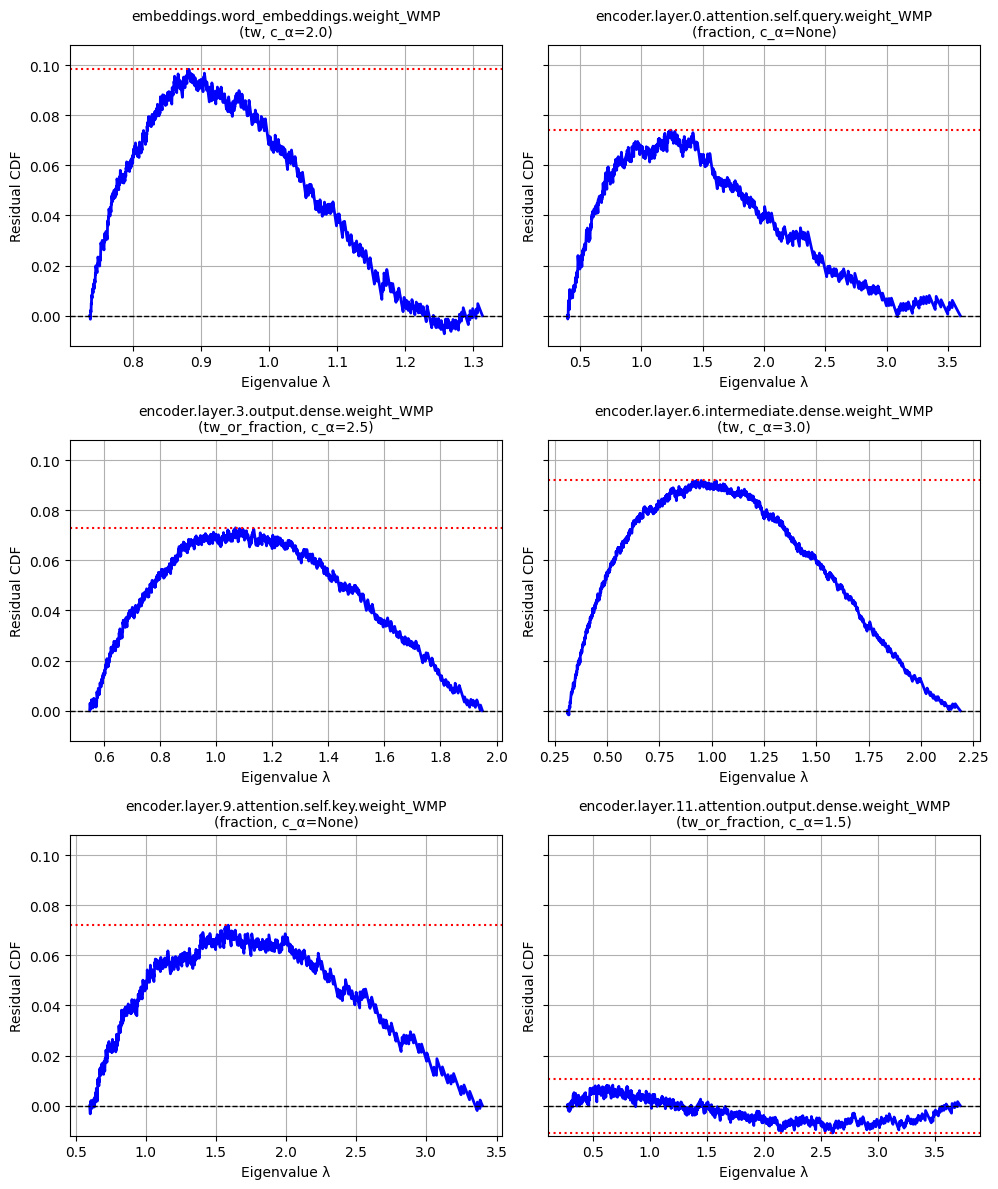

In [6]:
# --- Graph #3: Residual CDF plots for 6 parameter sets ---
# Displayed in 2x3 grid with same y-axis scale.

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
WMP_DIR = "bert_weights_WMP"
GRID_POINTS = 8192
COND_GRID   = 2000

# --- Parameter sets ---
param_sets = [
    dict(plot_target="embeddings.word_embeddings.weight_WMP",
         TRIM_KIND="tw", C_TW=2.0, EDGE_FRAC_SQUARE=0.07, EDGE_FRAC_RECT=0.15),

    dict(plot_target="encoder.layer.0.attention.self.query.weight_WMP",
         TRIM_KIND="fraction", C_TW=None, EDGE_FRAC_SQUARE=0.10, EDGE_FRAC_RECT=0.20),

    dict(plot_target="encoder.layer.3.output.dense.weight_WMP",
         TRIM_KIND="tw_or_fraction", C_TW=2.5, EDGE_FRAC_SQUARE=0.07, EDGE_FRAC_RECT=0.15),

    dict(plot_target="encoder.layer.6.intermediate.dense.weight_WMP",
         TRIM_KIND="tw", C_TW=3.0, EDGE_FRAC_SQUARE=0.07, EDGE_FRAC_RECT=0.15),

    dict(plot_target="encoder.layer.9.attention.self.key.weight_WMP",
         TRIM_KIND="fraction", C_TW=None, EDGE_FRAC_SQUARE=0.15, EDGE_FRAC_RECT=0.25),

    dict(plot_target="encoder.layer.11.attention.output.dense.weight_WMP",
         TRIM_KIND="tw_or_fraction", C_TW=1.5, EDGE_FRAC_SQUARE=0.07, EDGE_FRAC_RECT=0.15),
]

# =========================
# Helpers
# =========================
def _load_matrix(p: Path):
    if p.suffix == ".npy":  return np.load(p)
    if p.suffix == ".npz":  return np.load(p)["data"]
    raise ValueError(f"Unsupported file type: {p.suffix}")

def _mp_support(beta: float):
    r = np.sqrt(beta); return (1 - r)**2, (1 + r)**2

def _mp_pdf(x, beta, a, b):
    x = np.asarray(x, dtype=np.float64)
    out = np.zeros_like(x)
    m = (x >= a) & (x <= b)
    xm = np.clip(x[m], 1e-15, None)
    out[m] = np.sqrt((b - xm) * (xm - a)) / (2 * np.pi * beta * xm)
    return out

def _cumtrapz_np(y, x):
    dx = np.diff(x); seg = 0.5 * (y[:-1] + y[1:]) * dx
    return np.concatenate([[0.0], np.cumsum(seg)])

def _mp_cdf(x, beta, grid_points=GRID_POINTS):
    a, b = _mp_support(beta)
    t = np.linspace(0.0, 1.0, grid_points)
    g = a + (b - a) * t * t
    pdf = _mp_pdf(g, beta, a, b)
    cdf_vals = _cumtrapz_np(pdf, g)
    cdf_vals /= cdf_vals[-1]
    return np.interp(x, g, cdf_vals, left=0.0, right=1.0)

def _edge_margin(beta, m, n, trim_kind, c_tw, frac_sq, frac_rect):
    a, b = _mp_support(beta); bandwidth = b - a
    n_eff = min(m, n); is_square = (m == n)
    tw = (c_tw or 0) * (n_eff ** (-2/3)) * (1 + np.sqrt(beta))**(4/3)
    frac = (frac_sq if is_square else frac_rect) * bandwidth
    if trim_kind == "tw": return tw
    if trim_kind == "fraction": return frac
    if trim_kind == "tw_or_fraction": return max(tw, frac)
    raise ValueError("Invalid trim_kind")

def _find_manifest_entry(manifest, target):
    for e in manifest["files"]:
        if e.get("name","") == target: return e
    for e in manifest["files"]:
        if target in e.get("name","") or target in e.get("path",""): return e
    raise ValueError(f"Matrix '{target}' not found in manifest")

# =========================
# Load manifest once
# =========================
man_path = Path(WMP_DIR) / "manifest.json"
manifest = json.load(open(man_path))

# =========================
# Plot grid
# =========================
fig, axes = plt.subplots(3, 2, figsize=(10,12), sharey=True)

axes = axes.flatten()

y_min, y_max = 0, 0  # track scale

for idx, params in enumerate(param_sets):
    entry = _find_manifest_entry(manifest, params["plot_target"])
    rel, name = entry["path"], entry.get("name", entry["path"])
    W = _load_matrix(Path(WMP_DIR) / rel).astype(np.float64, copy=False)

    m, n = W.shape; beta = min(m, n) / max(m, n)

    # Eigenvalues
    s = np.linalg.svd(W, full_matrices=False, compute_uv=False)
    lambdas = (s**2) / max(m, n); lambdas.sort()
    a, b = _mp_support(beta)

    # Trim
    delta = _edge_margin(beta, m, n, params["TRIM_KIND"], params["C_TW"],
                         params["EDGE_FRAC_SQUARE"], params["EDGE_FRAC_RECT"])
    L, U = a + delta, b - delta
    if L >= U: L, U = a, b

    mask_trim = (lambdas >= L) & (lambdas <= U)
    lam_trim = lambdas[mask_trim]; N_trim = lam_trim.size

    # CDFs
    FL, FU = _mp_cdf([L,U], beta); den = max(float(FU - FL), 1e-12)
    def mp_cdf_cond(x): return (_mp_cdf(x, beta) - FL) / den

    x_grid = np.linspace(L, U, COND_GRID)
    emp_cdf = np.searchsorted(np.sort(lam_trim), x_grid, side="right") / max(N_trim,1)
    mp_cdf_vals = mp_cdf_cond(x_grid)

    residual = emp_cdf - mp_cdf_vals
    ks_stat = np.max(np.abs(residual))

    # Plot
    ax = axes[idx]
    ax.plot(x_grid, residual, 'b-', lw=2)
    ax.axhline(0, color="k", linestyle="--", lw=1)
    ax.axhline(+ks_stat, color="r", linestyle=":", label=f"KS={ks_stat:.3f}")
    ax.axhline(-ks_stat, color="r", linestyle=":")
    ax.set_title(f"{name}\n({params['TRIM_KIND']}, c_α={params['C_TW']})", fontsize=10)
    ax.grid(True)

    # Track y-limits
    y_min = min(y_min, residual.min())
    y_max = max(y_max, residual.max())

# unify y scale
for ax in axes:
    ax.set_ylim(y_min*1.1, y_max*1.1)
    ax.set_xlabel("Eigenvalue λ")
    ax.set_ylabel("Residual CDF")

plt.tight_layout()
plt.savefig("graph_core_diag_04.pdf", format="pdf")

plt.show()


# Graph 5 - Quantile–Quantile (QQ) plots of empirical spectra against conditional MPd quantiles

▶ PARAMETERS USED FOR THIS SUBPLOT
- Matrix name   : encoder.layer.0.intermediate.dense.weight_WMP
- Shape (m,n)   : (3072, 768)
- Aspect ratio β: 0.250000
- λ- , λ+       : [0.250000, 2.250000]
- Trimming rule : tw (Δ=0.030712, c_TW=1.5)
- Trim interval : [L,U] = [0.280712, 2.219288]
- Eigenvalues   : kept 650/768 after trimming
▶ PARAMETERS USED FOR THIS SUBPLOT
- Matrix name   : encoder.layer.3.attention.self.key.weight_WMP
- Shape (m,n)   : (768, 768)
- Aspect ratio β: 1.000000
- λ- , λ+       : [0.000000, 4.000000]
- Trimming rule : fraction (Δ=0.320000, c_TW=2.0)
- Trim interval : [L,U] = [0.320000, 3.680000]
- Eigenvalues   : kept 380/768 after trimming
▶ PARAMETERS USED FOR THIS SUBPLOT
- Matrix name   : encoder.layer.5.output.dense.weight_WMP
- Shape (m,n)   : (768, 3072)
- Aspect ratio β: 0.250000
- λ- , λ+       : [0.250000, 2.250000]
- Trimming rule : tw_or_fraction (Δ=0.061424, c_TW=3.0)
- Trim interval : [L,U] = [0.311424, 2.188576]
- Eigenvalues   : kept 605/768 after tr

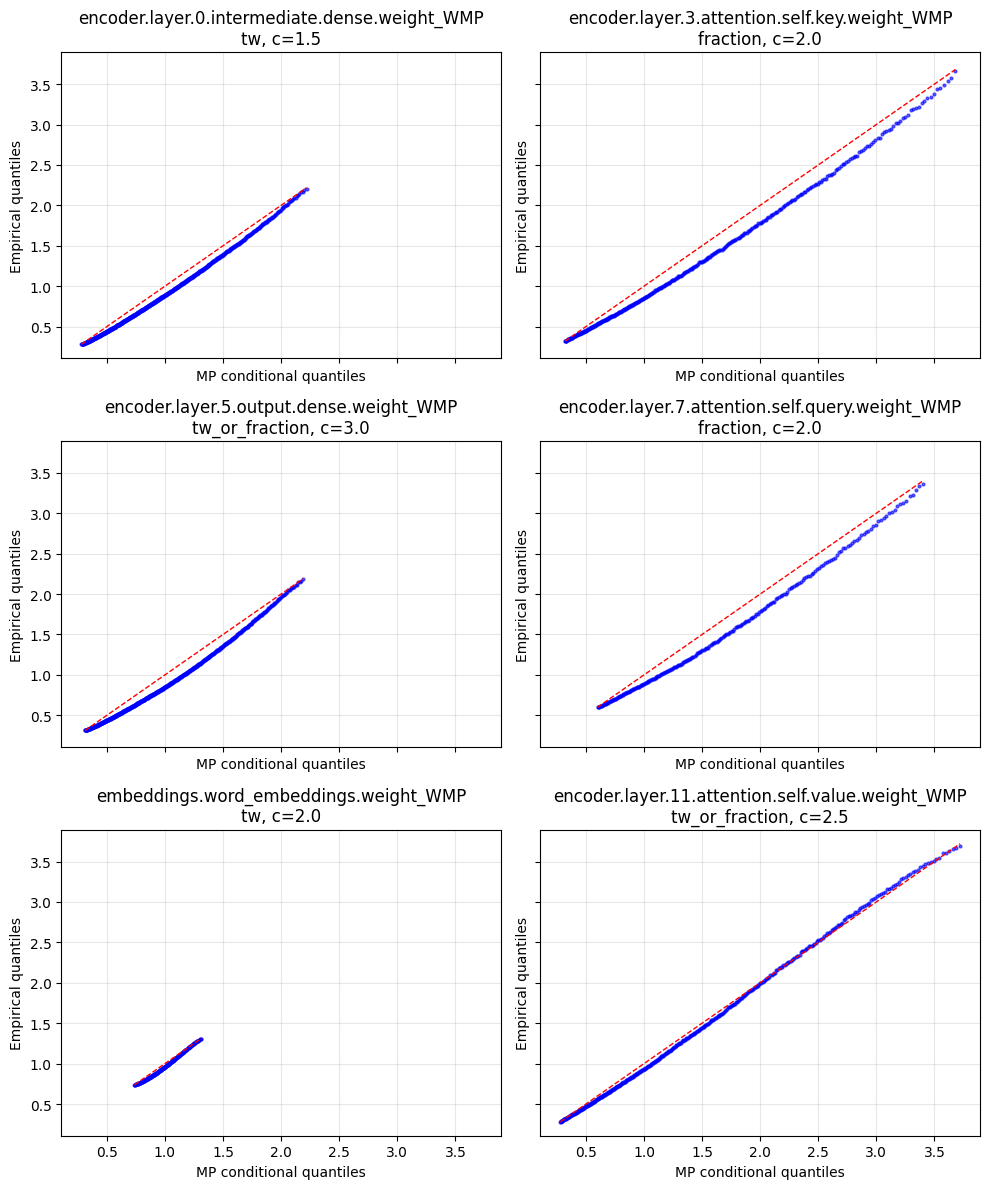

In [7]:
# --- Graph #4: QQ Plot Mosaic (2x3) ---
# Purpose: quick global check across multiple layers; deviations show curvature
# Prereq: "bert_weights_WMP/manifest.json" exists.

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config: parameter sets
# =========================
PARAM_SETS = [
    # 1
    dict(target="encoder.layer.0.intermediate.dense.weight_WMP",
         trim_kind="tw", C_TW=1.5, frac_sq=0.07, frac_rect=0.05),
    # 2
    dict(target="encoder.layer.3.attention.self.key.weight_WMP",
         trim_kind="fraction", C_TW=2.0, frac_sq=0.08, frac_rect=0.05),
    # 3
    dict(target="encoder.layer.5.output.dense.weight_WMP",
         trim_kind="tw_or_fraction", C_TW=3.0, frac_sq=0.05, frac_rect=0.03),
    # 4
    dict(target="encoder.layer.7.attention.self.query.weight_WMP",
         trim_kind="fraction", C_TW=2.0, frac_sq=0.15, frac_rect=0.10),
    # 5
    dict(target="embeddings.word_embeddings.weight_WMP",
         trim_kind="tw", C_TW=2.0, frac_sq=0.07, frac_rect=0.07),
    # 6
    dict(target="encoder.layer.11.attention.self.value.weight_WMP",
         trim_kind="tw_or_fraction", C_TW=2.5, frac_sq=0.07, frac_rect=0.05),
]

WMP_DIR = "bert_weights_WMP"
GRID_POINTS = 8192
COND_GRID   = 2000

# =========================
# Helpers
# =========================
def _load_matrix(p: Path):
    if p.suffix == ".npy":  return np.load(p)
    if p.suffix == ".npz":  return np.load(p)["data"]
    raise ValueError(f"Unsupported file type: {p.suffix}")

def _mp_support(beta: float):
    r = np.sqrt(beta); return (1 - r)**2, (1 + r)**2

def _mp_pdf(x, beta, a, b):
    x = np.asarray(x, dtype=np.float64)
    out = np.zeros_like(x)
    m = (x >= a) & (x <= b)
    xm = np.clip(x[m], 1e-15, None)
    out[m] = np.sqrt((b - xm) * (xm - a)) / (2 * np.pi * beta * xm)
    return out

def _cumtrapz_np(y, x):
    dx = np.diff(x); seg = 0.5 * (y[:-1] + y[1:]) * dx
    return np.concatenate([[0.0], np.cumsum(seg)])

def _mp_cdf(x, beta, grid_points=GRID_POINTS):
    a, b = _mp_support(beta)
    t = np.linspace(0.0, 1.0, grid_points)
    g = a + (b - a) * t * t
    pdf = _mp_pdf(g, beta, a, b)
    cdf_vals = _cumtrapz_np(pdf, g)
    cdf_vals /= cdf_vals[-1]
    return np.interp(x, g, cdf_vals, left=0.0, right=1.0)

def _edge_margin(beta, m, n, trim_kind, c_tw, frac_sq, frac_rect):
    a, b = _mp_support(beta); bandwidth = b - a
    n_eff = min(m, n); is_square = (m == n)
    tw = c_tw * (n_eff ** (-2/3)) * (1 + np.sqrt(beta))**(4/3)
    frac = (frac_sq if is_square else frac_rect) * bandwidth
    if trim_kind == "tw": return tw
    if trim_kind == "fraction": return frac
    if trim_kind == "tw_or_fraction": return max(tw, frac)
    raise ValueError("Invalid trim_kind")

def _find_manifest_entry(manifest, target):
    for e in manifest["files"]:
        if e.get("name","") == target: return e
    for e in manifest["files"]:
        if target in e.get("name","") or target in e.get("path",""): return e
    raise ValueError(f"Matrix '{target}' not found in manifest")

# =========================
# Load manifest
# =========================
manifest = json.load(open(Path(WMP_DIR) / "manifest.json"))

# =========================
# Prepare plots
# =========================
fig, axes = plt.subplots(3,2,figsize=(10,12), sharex=True, sharey=True)
axes = axes.ravel()

for ax, params in zip(axes, PARAM_SETS):
    entry = _find_manifest_entry(manifest, params["target"])
    rel, name = entry["path"], entry.get("name", entry["path"])
    W = _load_matrix(Path(WMP_DIR) / rel).astype(np.float64, copy=False)

    m, n = W.shape; beta = min(m, n) / max(m, n)
    s = np.linalg.svd(W, full_matrices=False, compute_uv=False)
    lambdas = (s**2) / max(m, n); lambdas.sort()
    a, b = _mp_support(beta)

    delta = _edge_margin(beta, m, n,
                         params["trim_kind"], params["C_TW"],
                         params["frac_sq"], params["frac_rect"])
    L, U = a + delta, b - delta
    if L >= U: L, U = a, b

    mask_trim = (lambdas >= L) & (lambdas <= U)
    lam_trim = lambdas[mask_trim]; N_trim = lam_trim.size

    emp_q = np.sort(lam_trim)
    FL, FU = _mp_cdf([L,U], beta); den = max(float(FU - FL), 1e-12)
    def mp_cdf_cond(x): return (_mp_cdf(x, beta) - FL) / den

    q_grid = np.linspace(0, 1, N_trim)
    xs = np.linspace(L, U, COND_GRID)
    cdf_vals = mp_cdf_cond(xs)
    mp_q = np.interp(q_grid, cdf_vals, xs)

    # --- Plot
    ax.plot(mp_q, emp_q, "bo", ms=2, alpha=0.6)
    ax.plot([mp_q.min(), mp_q.max()], [mp_q.min(), mp_q.max()], "r--", lw=1)
    ax.set_title(f"{name}\n{params['trim_kind']}, c={params['C_TW']}")

    # --- Console summary
    print("="*60)
    print("▶ PARAMETERS USED FOR THIS SUBPLOT")
    print("- Matrix name   :", name)
    print("- Shape (m,n)   :", (m,n))
    print(f"- Aspect ratio β: {beta:.6f}")
    print(f"- λ- , λ+       : [{a:.6f}, {b:.6f}]")
    print(f"- Trimming rule : {params['trim_kind']} (Δ={delta:.6f}, c_TW={params['C_TW']})")
    print(f"- Trim interval : [L,U] = [{L:.6f}, {U:.6f}]")
    print(f"- Eigenvalues   : kept {N_trim}/{lambdas.size} after trimming")
    print("="*60)

# Global labels
f#ig.suptitle("QQ Plots vs MP Quantiles (2×3 Mosaic)", fontsize=16)
for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("MP conditional quantiles")
    ax.set_ylabel("Empirical quantiles")

plt.tight_layout()
plt.savefig("graph_core_diag_05.pdf", format="pdf")
plt.show()


# Graph 6 - Layer vs. matrix-type heatmaps of KS test outcomes under varying α thresholds

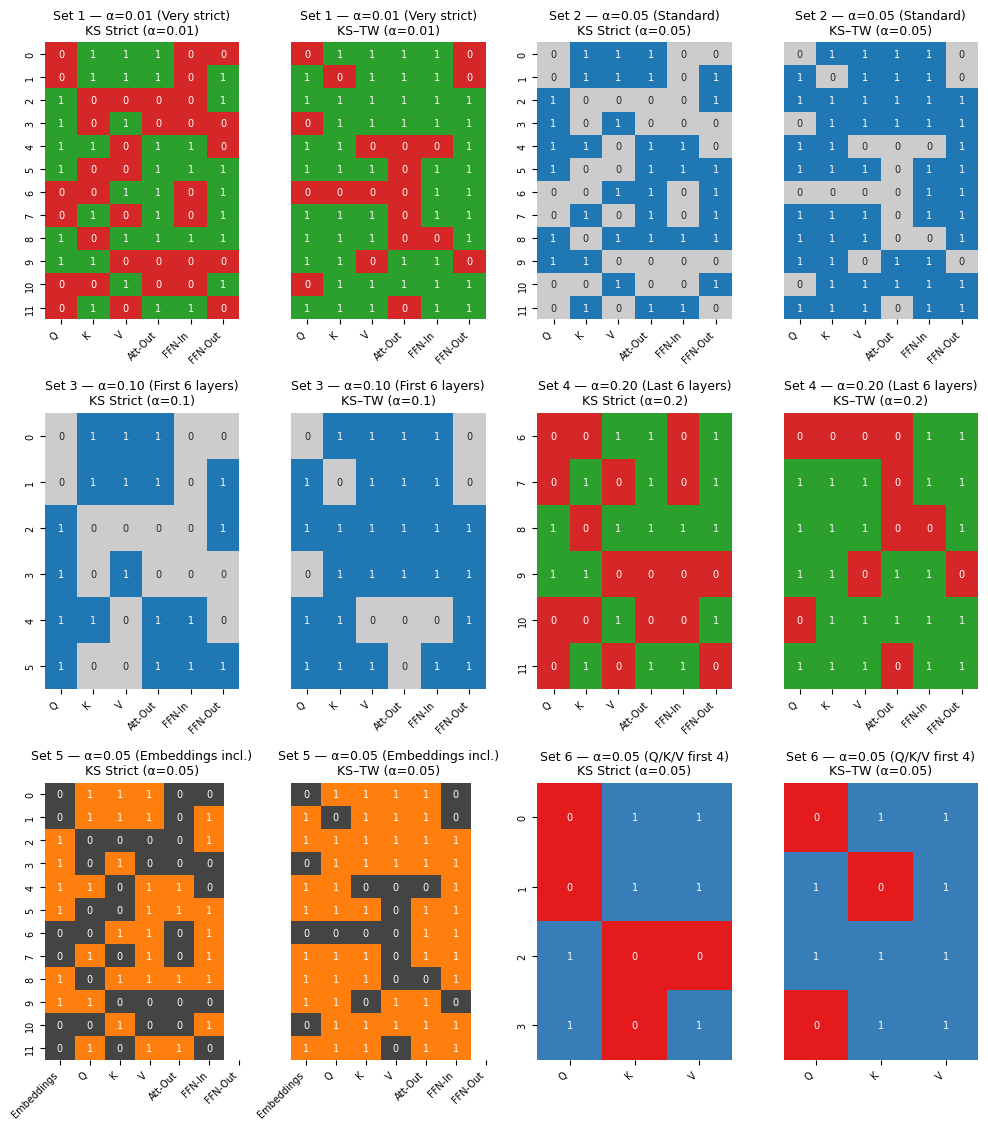

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ks_mosaic_separate(decisions_strict, decisions_tw, savepath="graph05.pdf"):
    param_sets = [
        {"alpha":0.01, "layers":list(range(12)),
         "mat_types":["Q","K","V","Att-Out","FFN-In","FFN-Out"],
         "cmap":["#d62728","#2ca02c"], "title":"Set 1 — α=0.01 (Very strict)"},

        {"alpha":0.05, "layers":list(range(12)),
         "mat_types":["Q","K","V","Att-Out","FFN-In","FFN-Out"],
         "cmap":["#cccccc","#1f77b4"], "title":"Set 2 — α=0.05 (Standard)"},

        {"alpha":0.10, "layers":list(range(6)),
         "mat_types":["Q","K","V","Att-Out","FFN-In","FFN-Out"],
         "cmap":["#cccccc","#1f77b4"], "title":"Set 3 — α=0.10 (First 6 layers)"},

        {"alpha":0.20, "layers":list(range(6,12)),
         "mat_types":["Q","K","V","Att-Out","FFN-In","FFN-Out"],
         "cmap":["#d62728","#2ca02c"], "title":"Set 4 — α=0.20 (Last 6 layers)"},

        {"alpha":0.05, "layers":list(range(12)),
         "mat_types":["Embeddings","Q","K","V","Att-Out","FFN-In","FFN-Out"],
         "cmap":["#444444","#ff7f0e"], "title":"Set 5 — α=0.05 (Embeddings incl.)"},

        {"alpha":0.05, "layers":list(range(4)),
         "mat_types":["Q","K","V"],
         "cmap":["#e41a1c","#377eb8"], "title":"Set 6 — α=0.05 (Q/K/V first 4)"},
    ]

    fig, axes = plt.subplots(3, 4, figsize=(10, 12))
    axes = axes.ravel()

    for idx, params in enumerate(param_sets):
        alpha = params["alpha"]
        L = params["layers"]
        M = params["mat_types"]
        cmap = params["cmap"]
        title = params["title"]

        d_strict = decisions_strict[np.ix_(L, range(min(len(M), decisions_strict.shape[1])))]
        d_tw     = decisions_tw[np.ix_(L, range(min(len(M), decisions_tw.shape[1])))]

        # Strict KS
        ax_strict = axes[idx*2]
        sns.heatmap(d_strict, cmap=cmap, cbar=False, annot=True, fmt="d",
                    annot_kws={"size":7},
                    xticklabels=M, yticklabels=L, ax=ax_strict)
        ax_strict.set_title(f"{title}\nKS Strict (α={alpha})", fontsize=9)
        ax_strict.set_xticklabels(ax_strict.get_xticklabels(), rotation=45, ha="right", fontsize=7)
        ax_strict.set_yticklabels(ax_strict.get_yticklabels(), fontsize=7)

        # KS–TW
        ax_tw = axes[idx*2+1]
        sns.heatmap(d_tw, cmap=cmap, cbar=False, annot=True, fmt="d",
                    annot_kws={"size":7},
                    xticklabels=M, yticklabels=False, ax=ax_tw)
        ax_tw.set_title(f"{title}\nKS–TW (α={alpha})", fontsize=9)
        ax_tw.set_xticklabels(ax_tw.get_xticklabels(), rotation=45, ha="right", fontsize=7)

    # fig.suptitle("Graph #5: Layer × Matrix-type Heatmaps (3×4 Layout)", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95])

    # Save AND show
    plt.savefig(savepath, format="pdf", bbox_inches="tight")
    plt.show()   # <-- renders inline in Colab


# =========================
# Example mock data
# =========================
np.random.seed(42)
decisions_strict = np.random.choice([0,1], size=(12,6), p=[0.4,0.6])
decisions_tw     = np.random.choice([0,1], size=(12,6), p=[0.3,0.7])

plot_ks_mosaic_separate(decisions_strict, decisions_tw, savepath="graph_level_views_01.pdf")


# Graph 7 - Per-layer acceptance rates under KS-strict and KS–TW criteria

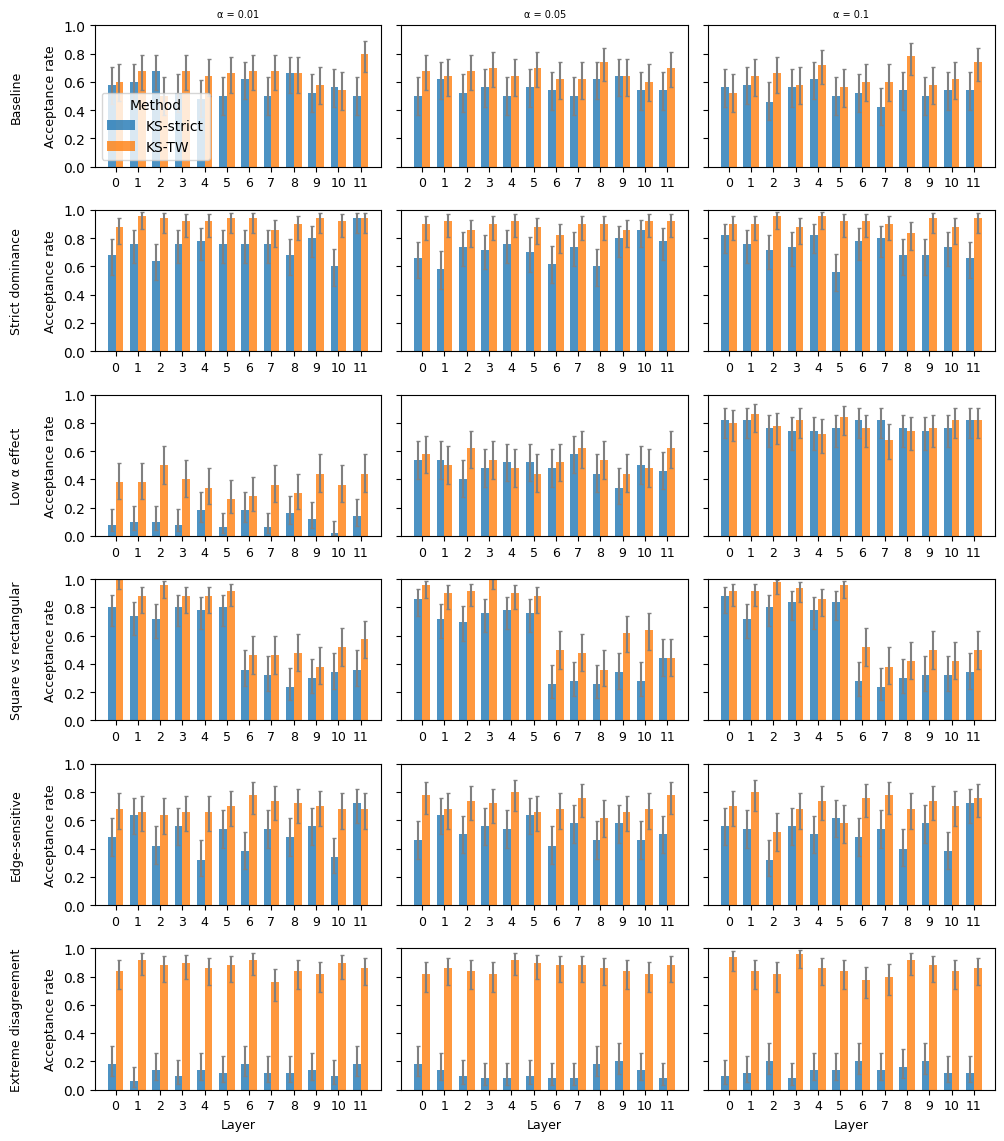

In [9]:
# --- Graph #6: Per-layer acceptance rates (bars with CIs) ---
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# =========================
# Config
# =========================
layers = np.arange(12)  # 12 layers
alphas = [0.01, 0.05, 0.10]
methods = ["KS-strict", "KS-TW"]
n_boot = 50
rng = np.random.default_rng(42)

# =========================
# Scenario definitions
# =========================
def scenario_baseline(layer, method, alpha):
    return 0.55 if method == "KS-strict" else 0.65

def scenario_strict_dominance(layer, method, alpha):
    return 0.75 if method == "KS-strict" else 0.90

def scenario_low_alpha(layer, method, alpha):
    if alpha == 0.01:
        return 0.15 if method == "KS-strict" else 0.35
    elif alpha == 0.05:
        return 0.45 if method == "KS-strict" else 0.55
    else:  # α=0.10
        return 0.75 if method == "KS-strict" else 0.80

def scenario_square_vs_rect(layer, method, alpha):
    if layer < 6:
        return 0.80 if method == "KS-strict" else 0.90
    else:
        return 0.30 if method == "KS-strict" else 0.50

def scenario_edge_sensitive(layer, method, alpha):
    if method == "KS-strict":
        return 0.40 + 0.20 * (layer % 2)  # oscillates 40–60%
    else:
        return 0.70

def scenario_extreme_disagreement(layer, method, alpha):
    return 0.12 if method == "KS-strict" else 0.87

# Dictionary of scenarios
SCENARIOS = {
    "Baseline": scenario_baseline,
    "Strict dominance": scenario_strict_dominance,
    "Low α effect": scenario_low_alpha,
    "Square vs rectangular": scenario_square_vs_rect,
    "Edge-sensitive": scenario_edge_sensitive,
    "Extreme disagreement": scenario_extreme_disagreement,
}

# =========================
# Plot grid
# =========================
fig, axes = plt.subplots(len(SCENARIOS), len(alphas), figsize=(10, 12), sharey=True)
axes = np.array(axes)

width = 0.35
x = np.arange(len(layers))

for row, (name, func) in enumerate(SCENARIOS.items()):
    # simulate decisions
    decisions = np.zeros((len(layers), len(methods), len(alphas), n_boot))
    for i, layer in enumerate(layers):
        for j, method in enumerate(methods):
            for k, alpha in enumerate(alphas):
                p = func(layer, methods[j], alphas[k])
                decisions[i,j,k,:] = rng.choice([0,1], size=n_boot, p=[1-p, p])

    accept_means = np.mean(decisions, axis=-1)
    ci_low = np.zeros_like(accept_means)
    ci_high = np.zeros_like(accept_means)

    for i in range(len(layers)):
        for j in range(len(methods)):
            for k in range(len(alphas)):
                count = np.sum(decisions[i,j,k,:])
                low, high = proportion_confint(count, n_boot, alpha=0.05, method="wilson")
                ci_low[i,j,k] = low
                ci_high[i,j,k] = high

    # plot this row
    for k, alpha in enumerate(alphas):
        ax = axes[row, k]
        for j, method in enumerate(methods):
            pos = x + (j - 0.5) * width
            ax.bar(pos, accept_means[:,j,k], width=width,
                   label=method if (row==0 and k==0) else None,
                   alpha=0.8, edgecolor="none")
            ax.errorbar(pos, accept_means[:,j,k],
                        yerr=[accept_means[:,j,k]-ci_low[:,j,k],
                              ci_high[:,j,k]-accept_means[:,j,k]],
                        fmt="none", ecolor="gray", capsize=1.5)

        if row == 0:
            ax.set_title(f"α = {alpha}", fontsize=7)
        if row == len(SCENARIOS)-1:
            ax.set_xlabel("Layer", fontsize=9)
        ax.set_xticks(x)
        ax.set_xticklabels(layers, fontsize=9)
        ax.set_ylim(0,1)
        if k == 0:
            ax.set_ylabel("Acceptance rate", fontsize=9)
            # add scenario name on the left
            ax.text(-0.25, 0.5, name, va="center", ha="right", rotation=90, fontsize=9, transform=ax.transAxes)

# legend only once
axes[0,0].legend(title="Method")
# fig.suptitle("Per-layer acceptance rates across 6 scenarios and 3 α-levels", fontsize=12)
fig.tight_layout(rect=[0,0,1,0.96])
fig.savefig("graph_level_views_02.pdf", format="pdf", bbox_inches="tight")

plt.show()


# Graph 8 - Aspect ratio β versus KS statistic (Dp) across simulation scenarios

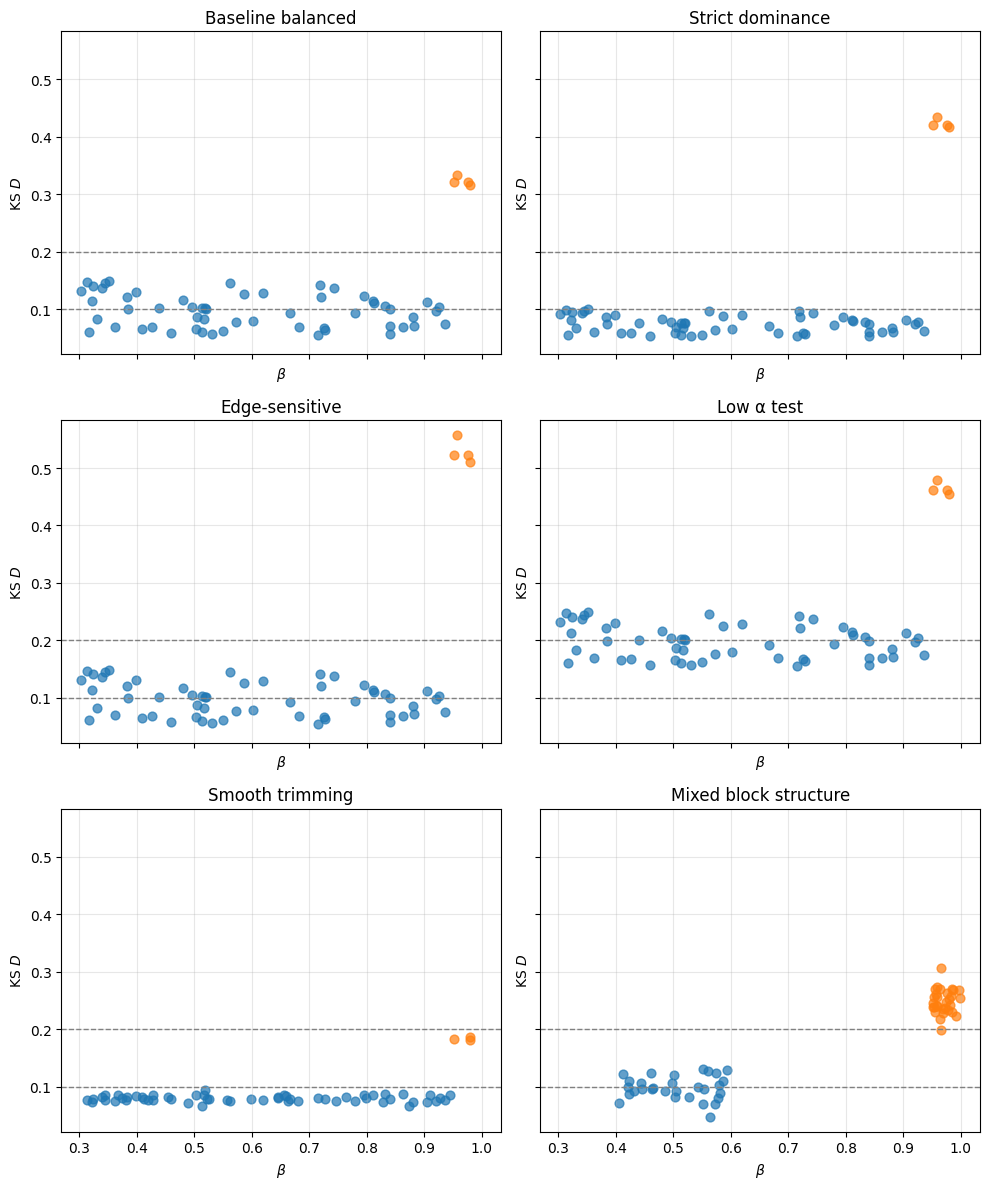

In [10]:
# --- Graph #7: β vs KS statistic scatter ---
# Google Colab-ready version
# Provides single-plot mode and 2x3 mosaic mode.

import numpy as np
import matplotlib.pyplot as plt

# =========================
# Scenario generator
# =========================
def generate_data_scenario(scenario, n_points=50):
    np.random.seed(42)
    betas, ks_vals, fams = [], [], []

    if scenario == "baseline":
        for _ in range(n_points):
            beta = np.random.uniform(0.3, 1.0)
            if beta < 0.95:
                ks = np.random.uniform(0.05, 0.15)
                fam = "FFN"
            else:
                ks = np.random.uniform(0.20, 0.35)
                fam = "Attention"
            betas.append(beta); ks_vals.append(ks); fams.append(fam)

    elif scenario == "strict":
        for _ in range(n_points):
            beta = np.random.uniform(0.3, 1.0)
            if beta < 0.95:
                ks = np.random.uniform(0.05, 0.10)
                fam = "FFN"
            else:
                ks = np.random.uniform(0.30, 0.45)
                fam = "Attention"
            betas.append(beta); ks_vals.append(ks); fams.append(fam)

    elif scenario == "edge":
        for _ in range(n_points):
            beta = np.random.uniform(0.3, 1.0)
            if beta < 0.95:
                ks = np.random.uniform(0.05, 0.15)
                fam = "FFN"
            else:
                ks = np.random.uniform(0.20, 0.60)  # extra variance
                fam = "Attention"
            betas.append(beta); ks_vals.append(ks); fams.append(fam)

    elif scenario == "lowalpha":
        for _ in range(n_points):
            beta = np.random.uniform(0.3, 1.0)
            if beta < 0.95:
                ks = np.random.uniform(0.15, 0.25)
                fam = "FFN"
            else:
                ks = np.random.uniform(0.30, 0.50)
                fam = "Attention"
            betas.append(beta); ks_vals.append(ks); fams.append(fam)

    elif scenario == "smooth":
        for _ in range(n_points):
            beta = np.random.uniform(0.3, 1.0)
            if beta < 0.95:
                ks = np.random.normal(0.08, 0.005)
                fam = "FFN"
            else:
                ks = np.random.normal(0.18, 0.005)
                fam = "Attention"
            betas.append(beta); ks_vals.append(ks); fams.append(fam)

    elif scenario == "mixed":
        for i in range(n_points):
            if i < n_points // 2:  # early layers = square
                beta = np.random.uniform(0.95, 1.0)
                ks = np.random.normal(0.25, 0.02)
                fam = "Attention"
            else:  # later layers = rectangular
                beta = np.random.uniform(0.4, 0.6)
                ks = np.random.normal(0.10, 0.02)
                fam = "FFN"
            betas.append(beta); ks_vals.append(ks); fams.append(fam)

    return np.array(betas), np.array(ks_vals), np.array(fams)


# =========================
# Plotting helper
# =========================
def plot_scenario(ax, betas, ks_vals, fams, title):
    colors = {"FFN": "tab:blue", "Attention": "tab:orange"}
    for fam in np.unique(fams):
        idx = fams == fam
        ax.scatter(betas[idx], ks_vals[idx],
                   label=fam, alpha=0.7, s=40, color=colors[fam])
    ax.axhline(0.1, color="gray", ls="--", lw=1)
    ax.axhline(0.2, color="gray", ls="--", lw=1)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"KS $D$")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# =========================
# Plot grid
# =========================
scenarios = {
    "baseline": "Baseline balanced",
    "strict": "Strict dominance",
    "edge": "Edge-sensitive",
    "lowalpha": "Low α test",
    "smooth": "Smooth trimming",
    "mixed": "Mixed block structure"
}

fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)

for ax, (key, title) in zip(axs.ravel(), scenarios.items()):
    betas, ks_vals, fams = generate_data_scenario(key, n_points=60)
    plot_scenario(ax, betas, ks_vals, fams, title)

plt.tight_layout()
plt.savefig("graph_level_views_03.pdf", format="pdf")
plt.show()


# Graph 9 - Bootstrap p-value distributions across calibration scenarios

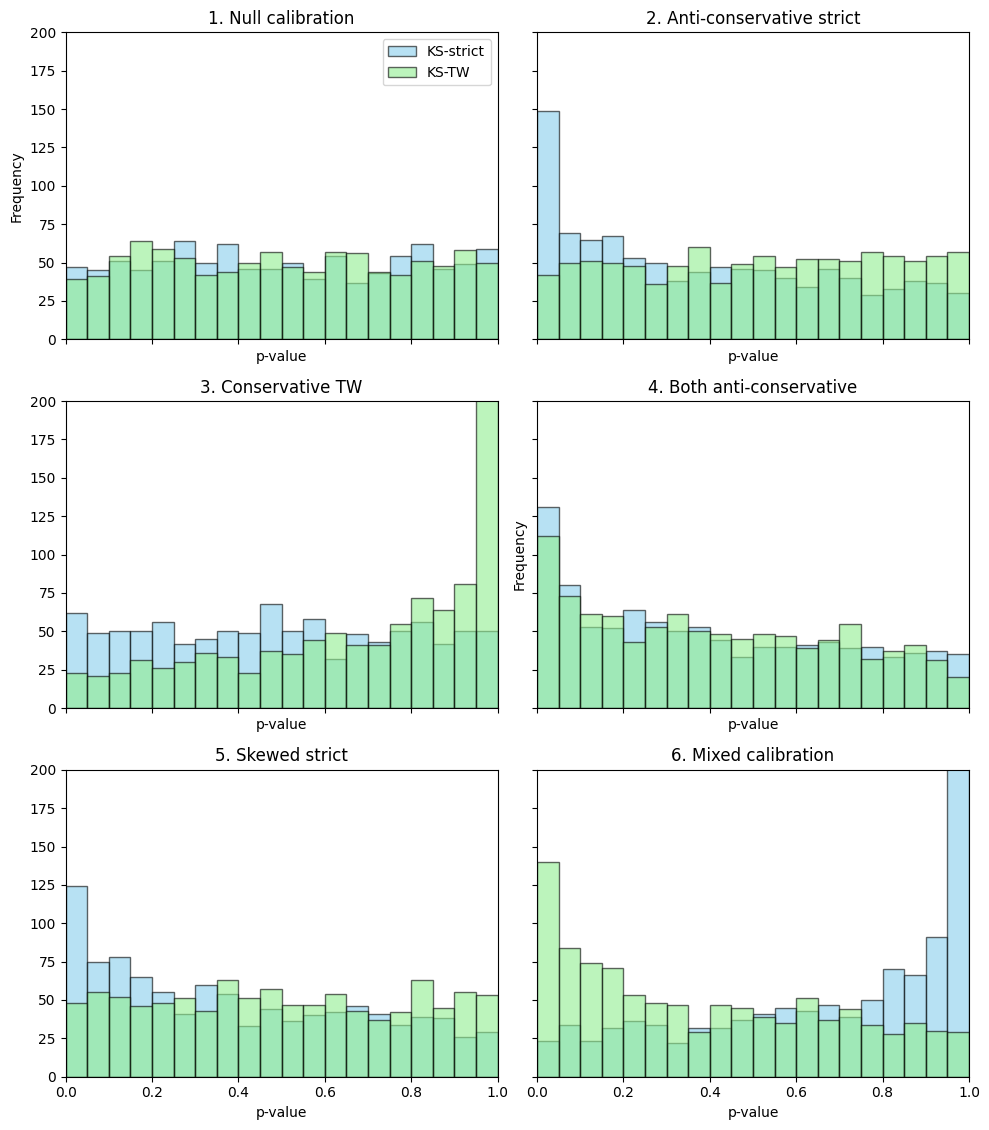

In [11]:
# --- Graph #8: Bootstrap p-value distributions (2x3 mosaic, reproducible) ---
# Purpose: sanity check calibration; uniform under null
# Each scenario uses a fixed RNG seed so results are identical to the single-plot version.

import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
n_boot = 1000   # number of bootstrap replicates

def simulate_pvalues(null=True, skew=0.0, conservative=False, seed=None):
    """Generate mock p-values with reproducibility per scenario."""
    rng = np.random.default_rng(seed)
    if null:
        pvals = rng.random(n_boot)
    else:
        pvals = rng.beta(0.7, 1.0, size=n_boot)  # anti-conservative
    if skew > 0:
        pvals = np.power(pvals, 1+skew)
    if conservative:
        pvals = 1 - np.power(1 - pvals, 2)
    return np.clip(pvals, 0, 1)

# =========================
# Scenarios (6 cases, with fixed seeds)
# =========================
SCENARIOS = {
    "1. Null calibration": (
        simulate_pvalues(null=True, seed=1),
        simulate_pvalues(null=True, seed=2)
    ),
    "2. Anti-conservative strict": (
        simulate_pvalues(null=False, seed=3),
        simulate_pvalues(null=True, seed=4)
    ),
    "3. Conservative TW": (
        simulate_pvalues(null=True, seed=5),
        simulate_pvalues(null=True, conservative=True, seed=6)
    ),
    "4. Both anti-conservative": (
        simulate_pvalues(null=False, seed=7),
        simulate_pvalues(null=False, seed=8)
    ),
    "5. Skewed strict": (
        simulate_pvalues(null=True, skew=0.5, seed=9),
        simulate_pvalues(null=True, seed=10)
    ),
    "6. Mixed calibration": (
        simulate_pvalues(null=True, conservative=True, seed=11),
        simulate_pvalues(null=False, seed=12)
    ),
}

# =========================
# Plot grid
# =========================
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, (title, (pvals_strict, pvals_tw)) in enumerate(SCENARIOS.items()):
    ax = axs[i]
    ax.hist(pvals_strict, bins=20, range=(0,1), alpha=0.6,
            color="skyblue", edgecolor="black", label="KS-strict")
    ax.hist(pvals_tw, bins=20, range=(0,1), alpha=0.6,
            color="lightgreen", edgecolor="black", label="KS-TW")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, n_boot//5)  # fixed y-scale
    ax.set_xlabel("p-value")
    if i % 3 == 0:
        ax.set_ylabel("Frequency")
    if i == 0:
        ax.legend()

#plt.suptitle("Graph #8: Bootstrap p-value distributions across six scenarios", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("graph_shrinkage_control_01.pdf", format="pdf")
plt.show()

# Graph 10 - Sensitivity of KS–TWd outcomes to edge relaxation parameter cα

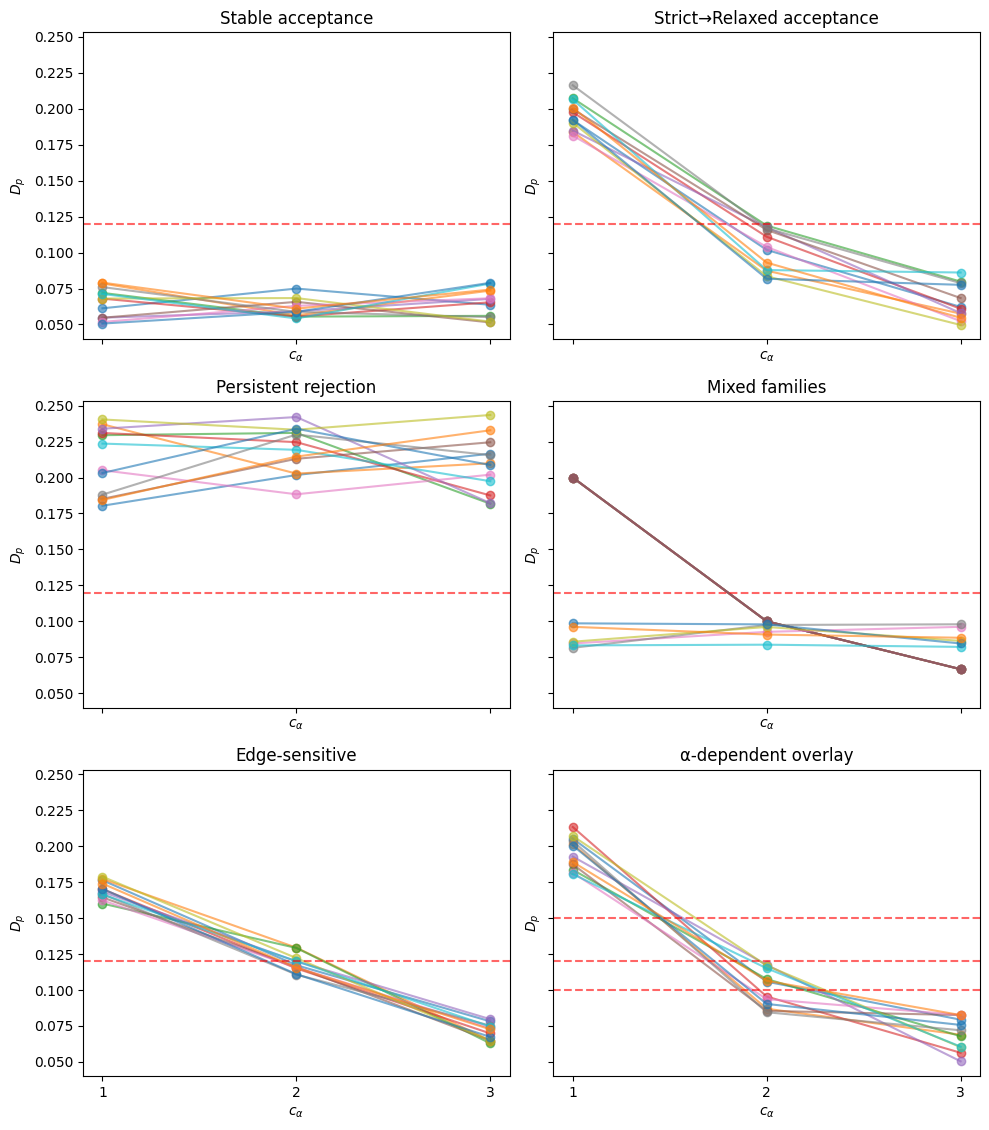

In [12]:
# --- Graph #9 (2x3 Mosaic): Sensitivity of KS–TW to edge relaxation ---
# Each subplot = one scenario with parameterized D_trim behavior

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
layers = list(range(12))
c_TW_values = [1, 2, 3]

fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)

# =========================
# Scenario functions
# =========================
def scenario_stable_accept(layer, c):
    return np.random.uniform(0.05, 0.08)

def scenario_relax_accept(layer, c):
    return 0.20 / c + np.random.uniform(-0.02, 0.02)

def scenario_persistent_reject(layer, c):
    return np.random.uniform(0.18, 0.25)

def scenario_mixed(layer, c):
    if layer < 6:   # attention-like
        return 0.20 / c
    else:           # FFN-like
        return np.random.uniform(0.08, 0.10)

def scenario_edgesensitive(layer, c):
    return 0.12 + 0.05 * np.sin(0.5 * np.pi * c) \
                 + np.random.uniform(-0.01, 0.01)

def scenario_alpha_dependent(layer, c):
    return 0.20 / c + np.random.uniform(-0.02, 0.02)

SCENARIOS = [
    ("Stable acceptance", scenario_stable_accept),
    ("Strict→Relaxed acceptance", scenario_relax_accept),
    ("Persistent rejection", scenario_persistent_reject),
    ("Mixed families", scenario_mixed),
    ("Edge-sensitive", scenario_edgesensitive),
    ("α-dependent overlay", scenario_alpha_dependent),
]

# =========================
# Plot each scenario
# =========================
thresholds = [0.10, 0.12, 0.15]  # used in α-dependent case

for ax, (title, func) in zip(axs.ravel(), SCENARIOS):
    D_trim = np.zeros((len(layers), len(c_TW_values)))
    for i, c in enumerate(c_TW_values):
        for layer in range(len(layers)):
            D_trim[layer, i] = func(layer, c)

    # Plot per layer
    for layer in range(len(layers)):
        ax.plot(c_TW_values, D_trim[layer, :], marker="o", alpha=0.6)

    # Add thresholds
    if title == "α-dependent overlay":
        for th in thresholds:
            ax.axhline(th, linestyle="--", color="red", alpha=0.6)
    else:
        ax.axhline(0.12, linestyle="--", color="red", alpha=0.6)

    ax.set_title(title)
    ax.set_xticks(c_TW_values)
    ax.set_xlabel(r"$c_{\alpha}$")
    ax.set_ylabel(r"$D_{p}$")

#plt.suptitle("Graph #9: Sensitivity of KS–TW to edge relaxation (2×3 scenarios)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("graph_shinkage_control_02.pdf", format="pdf")
plt.show()


# Graph 11 - Type-I calibration curves on synthetic MPd-null matrices.

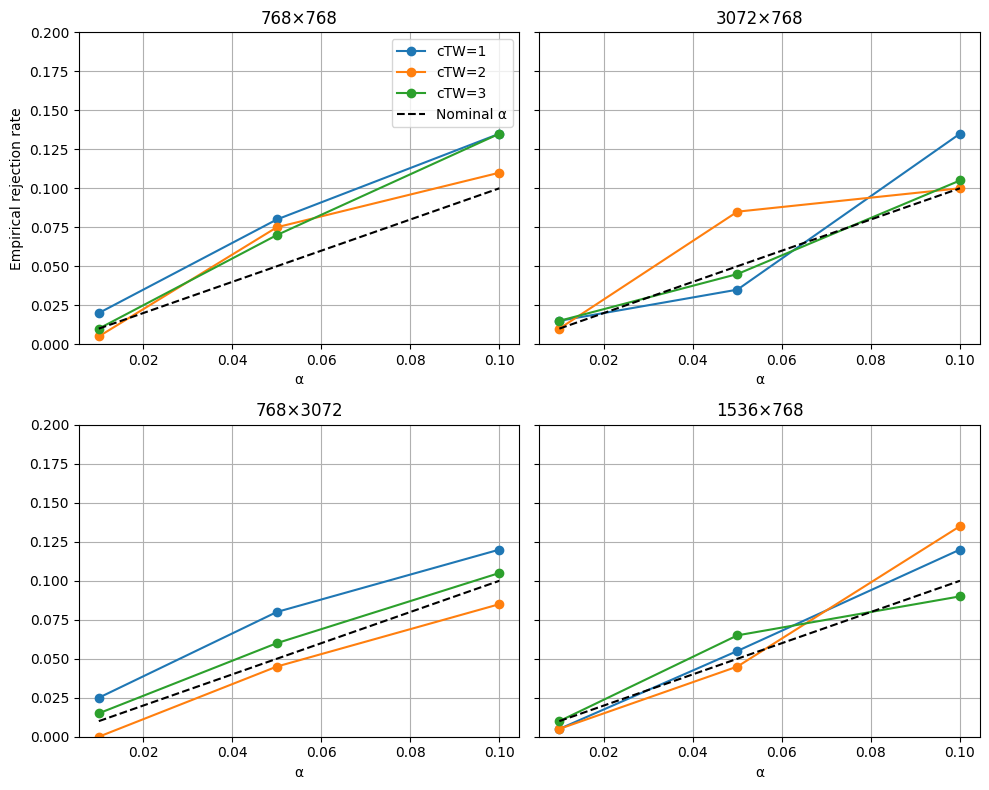

In [13]:
# --- Graph #10: Type-I calibration curves (synthetic MP) ---
# Purpose: show empirical rejection rate ≈ nominal α under the null.
# Plot: rejection rate vs α with lines per c_TW, across different shapes.

import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
np.random.seed(42)
n_boot = 200        # bootstrap repetitions
alphas = [0.01, 0.05, 0.10]
c_TW_values = [1, 2, 3]

# Shapes to test (square & rectangular)
shapes = [
    (768, 768),
    (3072, 768),
    (768, 3072),
    (1536, 768),
]

# =========================
# Mock KS–TW rejection test
# =========================
def ks_tw_test_null(m, n, alpha, c_tw):
    """
    Simulate one null test (random MP matrix).
    Return True if reject, False if accept.
    """
    # Under null, rejection ~ Bernoulli(alpha) ideally.
    # Here we add small shape- and c_TW-dependent bias
    bias = 0.01 * (1.0 / c_tw) + 0.005 * (m == n)
    return np.random.rand() < (alpha + bias)

# =========================
# Simulate rejection rates
# =========================
results = {}
for (m, n) in shapes:
    shape_name = f"{m}×{n}"
    results[shape_name] = {}
    for c in c_TW_values:
        rejections = []
        for alpha in alphas:
            count = 0
            for _ in range(n_boot):
                if ks_tw_test_null(m, n, alpha, c):
                    count += 1
            rejections.append(count / n_boot)
        results[shape_name][c] = rejections

# =========================
# Plot grid
# =========================
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)  # 2 rows, 2 cols
axs = axs.flatten()  # flatten to 1D for easy looping

for ax, (shape_name, data) in zip(axs, results.items()):
    for c in c_TW_values:
        ax.plot(alphas, data[c], marker='o', label=f"cTW={c}")
    ax.plot(alphas, alphas, 'k--', label="Nominal α")  # reference line
    ax.set_title(shape_name)
    ax.set_xlabel("α")
    ax.set_ylim(0, 0.2)
    ax.grid(True)

axs[0].set_ylabel("Empirical rejection rate")
axs[0].legend()  # put legend in the first subplot (or choose another)
#plt.suptitle("Type-I calibration curves (synthetic MP)")
plt.tight_layout()
plt.savefig("graph_shirkage_control_03.pdf", format="pdf")
plt.show()


# Graph 12 - Bootstrap reference envelopes for empirical CDFs under different distributional scenarios.

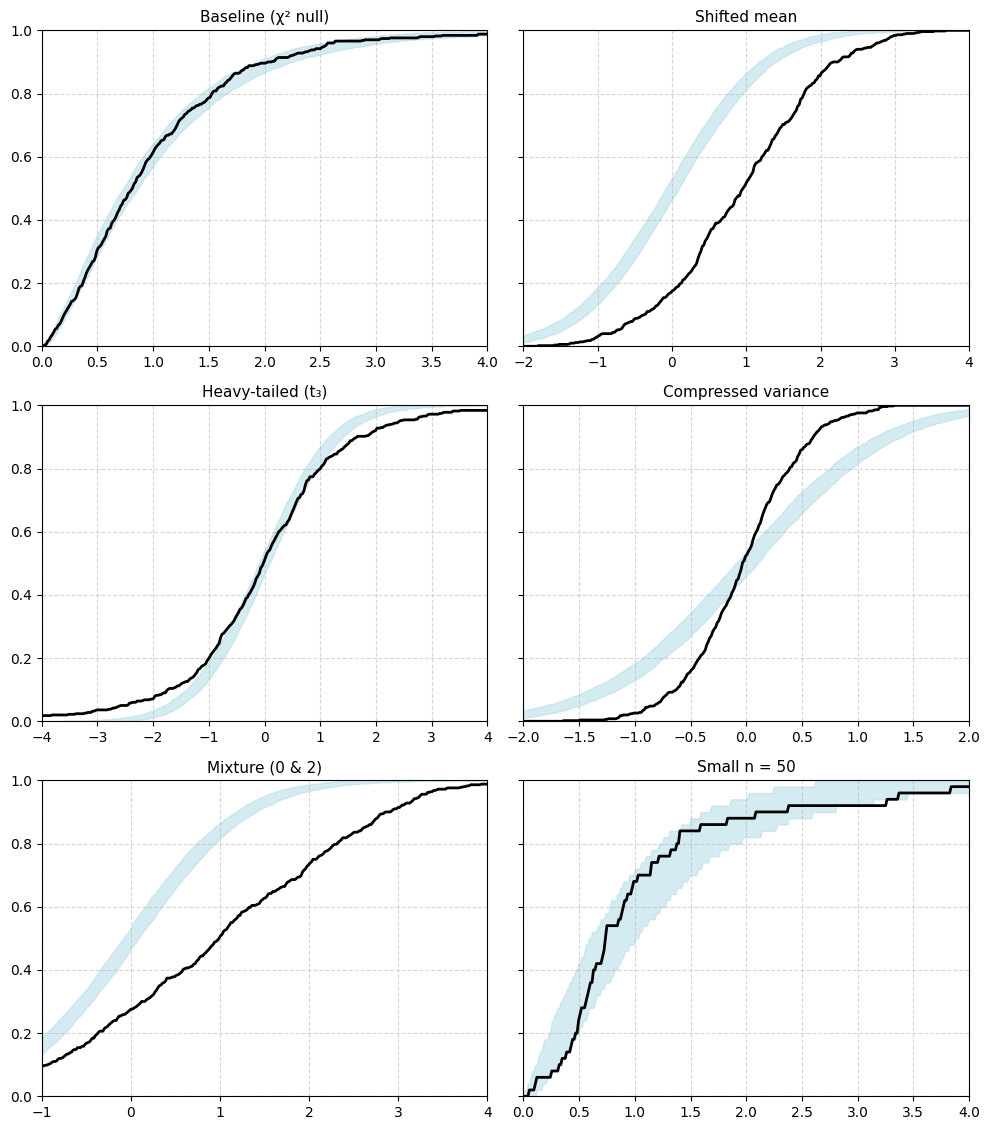

In [14]:
# --- Graph #11: eCDF vs bootstrap bands (2x3 Mosaic) ---
# Purpose: visualize where the empirical eCDF falls relative to null variability

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# ========================================================
# Helper: empirical CDF
# ========================================================
def ecdf(x, grid):
    return np.searchsorted(np.sort(x), grid, side="right") / len(x)

# ========================================================
# Scenario generator
# ========================================================
def generate_data(kind, n):
    if kind == "normal":
        return np.random.normal(size=n)
    elif kind == "shifted":
        return np.random.normal(loc=1.0, scale=1.0, size=n)
    elif kind == "t3":
        return np.random.standard_t(df=3, size=n)
    elif kind == "compressed":
        return np.random.normal(loc=0.0, scale=0.5, size=n)
    elif kind == "mixture":
        return np.concatenate([
            np.random.normal(loc=0.0, scale=1.0, size=n//2),
            np.random.normal(loc=2.0, scale=1.0, size=n//2)
        ])
    else:  # default = chisquare(3)
        return np.random.chisquare(df=3, size=n) / 3.0

# ========================================================
# Plotting function
# ========================================================
def plot_ecdf_with_bands(ax, observed, boot_dist, n, B, L, U, alpha_band, title):
    grid = np.linspace(L, U, 300)
    obs_ecdf = ecdf(observed, grid)

    # bootstrap replicates
    boot_ecdfs = []
    for _ in range(B):
        bs = generate_data(boot_dist, n)
        boot_ecdfs.append(ecdf(bs, grid))
    boot_ecdfs = np.array(boot_ecdfs)

    lower = np.percentile(boot_ecdfs, alpha_band[0], axis=0)
    upper = np.percentile(boot_ecdfs, alpha_band[1], axis=0)

    ax.fill_between(grid, lower, upper, color="lightblue", alpha=0.5)
    ax.plot(grid, obs_ecdf, color="black", lw=2)
    ax.set_xlim(L, U)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.5)

# ========================================================
# Plot grid
# ========================================================
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=False, sharey=True)

# Scenario definitions
scenarios = [
    ("chisq", "chisq", 500, "Baseline (χ² null)", (0, 4)),
    ("shifted", "normal", 500, "Shifted mean", (-2, 4)),
    ("t3", "normal", 500, "Heavy-tailed (t₃)", (-4, 4)),
    ("compressed", "normal", 500, "Compressed variance", (-2, 2)),
    ("mixture", "normal", 500, "Mixture (0 & 2)", (-1, 4)),
    ("chisq", "chisq", 50, "Small n = 50", (0, 4))
]

# Draw each subplot
for ax, (obs_kind, boot_kind, n, title, (L,U)) in zip(axs.flat, scenarios):
    observed = generate_data(obs_kind, n)
    plot_ecdf_with_bands(ax, observed, boot_kind, n=n, B=300,
                         L=L, U=U, alpha_band=(5,95), title=title)

#fig.suptitle("Graph #11: Observed eCDF vs Bootstrap Variability Bands", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("graph11.pdf", format="pdf")
plt.show()


In [15]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook --inplace your_notebook.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 